# Using a predefined random seed and saving the outputs at each step. This is for reproducibility. Simulation without noise

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline34IDC.optimization.common as opt_common
import aps.ai.autoalignment.beamline34IDC.optimization.configs as configs
import aps.ai.autoalignment.beamline34IDC.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
#from aps.ai.autoalignment.beamline34IDC.facade.focusing_optics_factory import (
#    ExecutionMode,
#    focusing_optics_factory_method,
#)

from aps.ai.autoalignment.beamline34IDC.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline34IDC.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline34IDC.simulation.facade.focusing_optics_interface import get_default_input_features
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam

import aps.ai.autoalignment.beamline34IDC.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline34IDC.optimization.analysis_plot_utils as apu
from datetime import datetime

import matplotlib as mpl
import cmasher as cm

from epics import ca
ca.finalize_libca()

%matplotlib inline

**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
mpl.rcParams.update({'font.size': 16, 'text.usetex':True})

In [122]:
DEFAULT_RANDOM_SEED = 12345

In [123]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 6e3,
            "sum_intensity_hard_constraint": 6e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["fwhm", "peak_distance"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm":0.02}
        }

In [124]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/34-ID"
    os.chdir(work_dir)

In [125]:
def print_beam_attributes(loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
        "negative_log_peak_intensity": lambda d: -np.log(opt_common._get_peak_intensity_from_dw(d))
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(opt_common._get_weighted_sum_intensity_from_hist(hist, 2))
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In experiments, the perturbed max is about 400 times higher than the noise level. This seems to hold in sim with noise level 0.5

In [127]:
detector_x = 0.05
detector_y = 0.05
cp = opt_common.CalculationParameters(
    xrange= [-detector_x / 2, detector_x / 2],
    yrange = [-detector_y / 2, detector_y / 2],
    nbins_h = 1024,
    nbins_v = 1024,
    use_denoised = False,
    random_seed = DEFAULT_RANDOM_SEED,
    add_noise = False,
    calculate_over_noise= False,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5,
    save_images=True,
    every_n_images=1
   )

xrange_plot = [-0.02, 0.02]
yrange_plot = [-0.02, 0.02]

ppm = opt_common.PlotParameters(xrange=xrange_plot, yrange=yrange_plot, nbins_h = cp.nbins_h // 2, nbins_v = cp.nbins_v // 2)


In [128]:
cur_dir = Path.cwd().resolve()

In [129]:
save_dir = Path(Path.home() / "code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_pi")

In [130]:
!rm -r $save_dir

In [131]:
save_dir.mkdir()

In [132]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.025, 0.025], yrange=[-0.025, 0.025], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=12345, add_noise=False, noise=0.5, percentage_fluctuation=50, calculate_over_noise=False, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=True, every_n_images=1, rng=Generator(PCG64) at 0x7FA0DA6E1820)


In [133]:
ppm

PlotParameters(implementor=0, title='X,Z', xrange=[-0.02, 0.02], yrange=[-0.02, 0.02], nbins_h=512, nbins_v=512, plot_mode=0, aspect_ratio=0, color_map=<matplotlib.colors.ListedColormap object at 0x7fa16844bdc0>)

In [134]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_trans': [-20, 20], 'vb_trans': [-20, 20], 'hb_pitch': [-0.02, 0.02], 'vb_pitch': [-0.02, 0.02], 'hb_1': [-30, 30], 'hb_2': [-30, 30], 'vb_1': [-30, 30], 'vb_2': [-30, 30]}
Optimization parameters
{'sum_intensity_soft_constraint': 6000.0, 'sum_intensity_hard_constraint': 6000.0, 'loss_parameters': ['fwhm', 'peak_distance'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [135]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features()
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=1,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    #layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


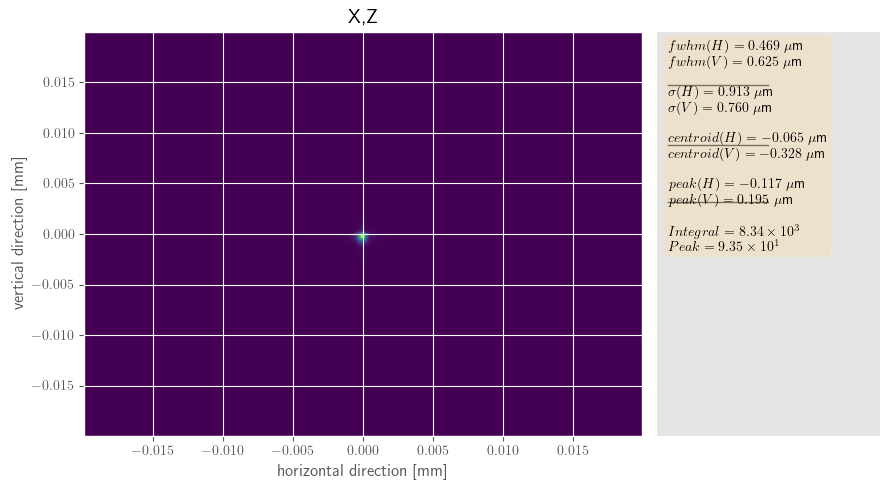

In [136]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp,focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [138]:
focused_beam = {'dw': dw, 'hist': hist}
joblib.dump(focused_beam, f'{save_dir}/focused_beam.joblib', compress=5)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_pi/focused_beam.joblib']

In [139]:
!pwd

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID


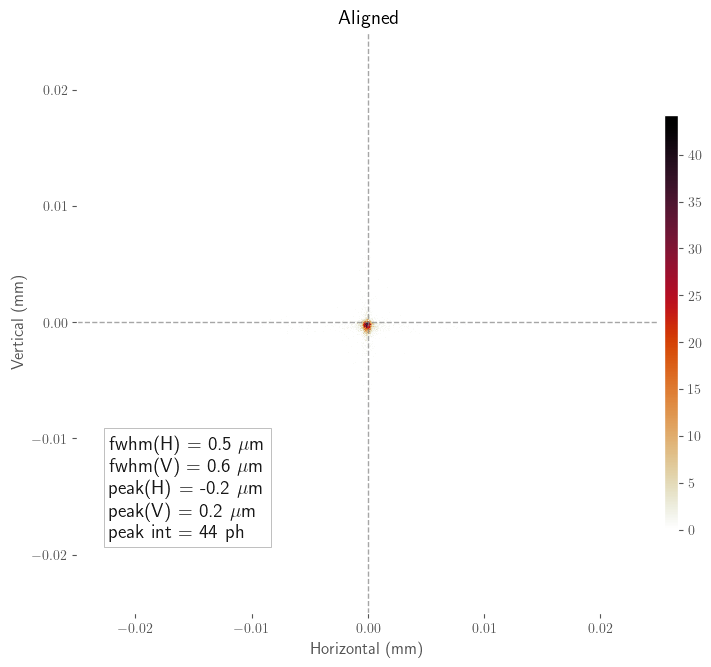

In [140]:
dwd = dw._DictionaryWrapper__dictionary

plt.figure(figsize=[7,7], constrained_layout=True)


plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2)
#plt.xlim(-0.025,0.025)
#plt.ylim(-0.025,0.025)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Aligned")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (fr"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
             fr"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph")
ax.text(0.055, 0.13, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7), transform=ax.transAxes)
plt.show()

(-0.02, 0.02)

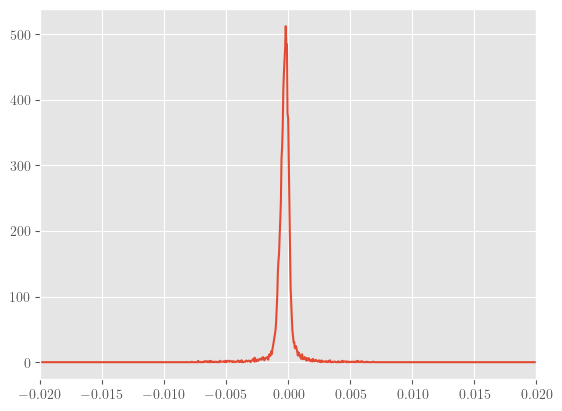

In [141]:
plt.plot(hist.hh, hist.data_2D.sum(axis=0))
plt.xlim([-0.02,0.02])

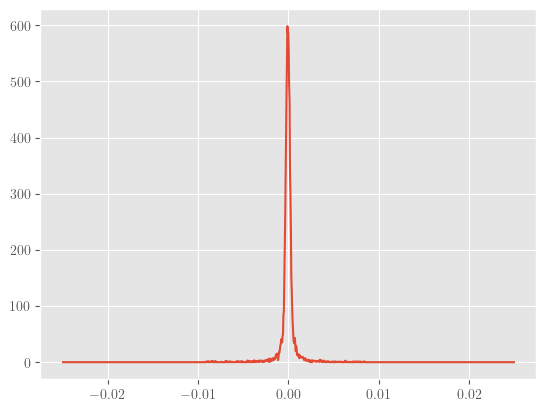

In [142]:
plt.plot(hist.vv, hist.data_2D.sum(axis=1))

In [143]:
attribs_focus = print_beam_attributes(opt_params.params['loss_parameters'], hist, dw, "Focused beam")

Focused beam system fwhm: 7.627e-04
Focused beam system peak_distance: 2.784e-04


In [144]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_trans': 0.0, 'vb_trans': 0.0, 'hb_pitch': 3.0000000000000506, 'vb_pitch': 3.0000000000000506, 'hb_1': 215.5, 'hb_2': 112.50000000000001, 'vb_1': 143.99999999999997, 'vb_2': 231.5}


In [145]:
random_move_ranges = {k: np.array(v) * 0.5 for k,v in opt_params.move_motors_ranges.items()}
random_move_ranges

{'hb_trans': array([-10.,  10.]),
 'vb_trans': array([-10.,  10.]),
 'hb_pitch': array([-0.01,  0.01]),
 'vb_pitch': array([-0.01,  0.01]),
 'hb_1': array([-15.,  15.]),
 'hb_2': array([-15.,  15.]),
 'vb_1': array([-15.,  15.]),
 'vb_2': array([-15.,  15.])}

In [146]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=random_move_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp,
    
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_trans', 'vb_trans', 'hb_pitch', 'vb_pitch', 'hb_1', 'hb_2', 'vb_1', 'vb_2'] [-5.495208764562103, -3.697849954815561, 3.0052359877560333, 3.003490658504039, 212.23329999999999, 107.48440000000004, 146.94929999999997, 222.10200000000003]
Random initialization is (RELATIVE) ['hb_trans', 'vb_trans', 'hb_pitch', 'vb_pitch', 'hb_1', 'hb_2'

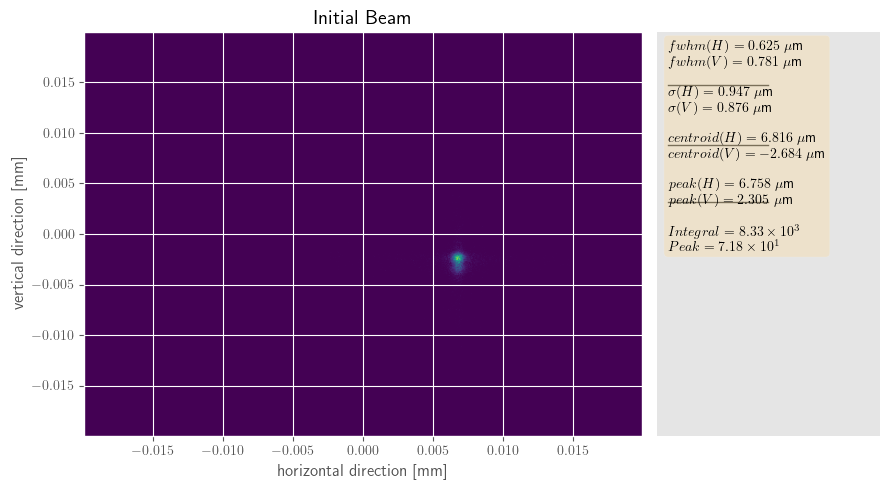

Perturbed beam system fwhm: 1.016e-03
Perturbed beam system peak_distance: 7.165e-03


In [147]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

In [148]:
hist_pert.data_2D.max()

28.968702221736606

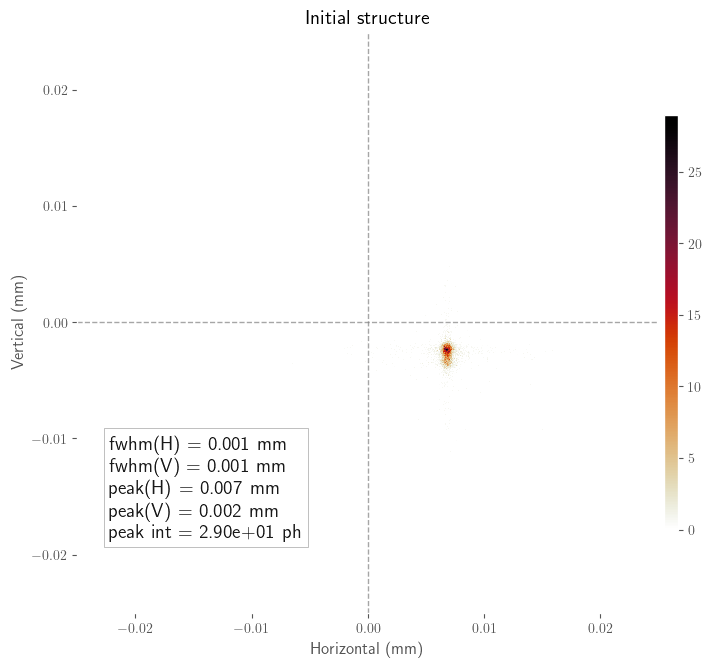

In [149]:
dwd = dw_pert._DictionaryWrapper__dictionary
plt.figure(figsize=[7,7], constrained_layout=True)
plt.pcolormesh(hist_pert.hh, hist_pert.vv, hist_pert.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
#plt.xlim(-0.05,0.05)
#plt.ylim(-0.05,0.05)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Initial structure")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (f"{'fwhm(H)':<6} = {dwd['h_fwhm']: 4.3f} mm\n"
             f"{'fwhm(V)':<9} = {dwd['v_fwhm']: 4.3f} mm\n"
             f"{'peak(H)':<9} = {dwd['h_peak']: 4.3f} mm\n"
             f"{'peak(V)':<9} = {dwd['v_peak']: 4.3f} mm\n"
             f"{'peak int':<9} = {dwd['peak_intensity']: 3.2e} ph")
ax.text(0.055, 0.13, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7), transform=ax.transAxes)
plt.show()

In [150]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

In [151]:
perturbed_positions

array([ -5.45327955,  -3.66483321,   3.00594731,   3.00352509,
       212.23328652, 107.48441784, 146.94926261, 222.10202557])

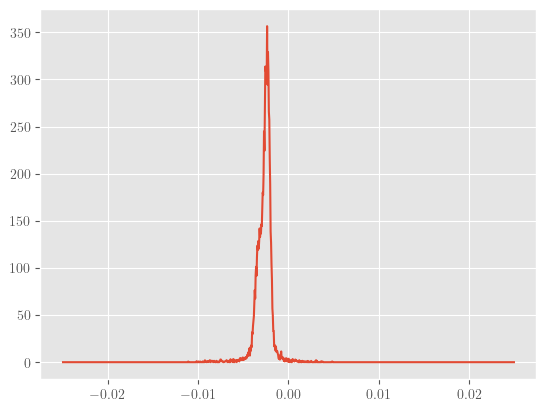

In [152]:
plt.plot(hist_pert.hh, hist_pert.data_2D.sum(axis=0))
#plt.xlim([-0.02,0.02])

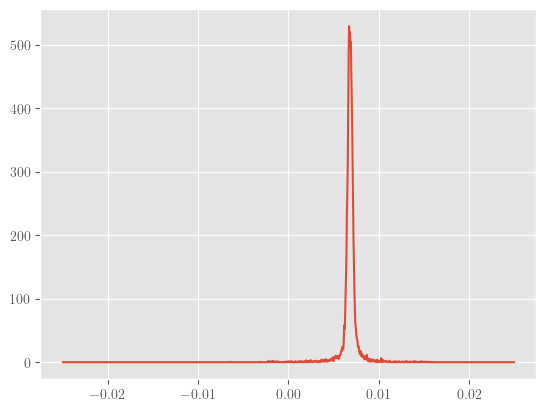

In [153]:
plt.plot(hist_pert.vv, hist_pert.data_2D.sum(axis=1))

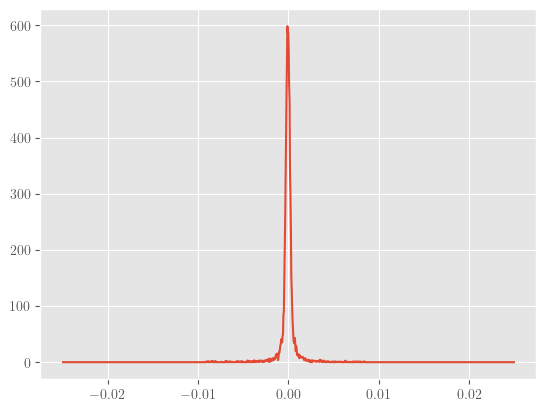

In [154]:
plt.plot(hist.vv, hist.data_2D.sum(axis=1))

In [155]:
hist.data_2D.sum()

8337.708788171103

#### Calculating without removing noise : two step optimization

In [156]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


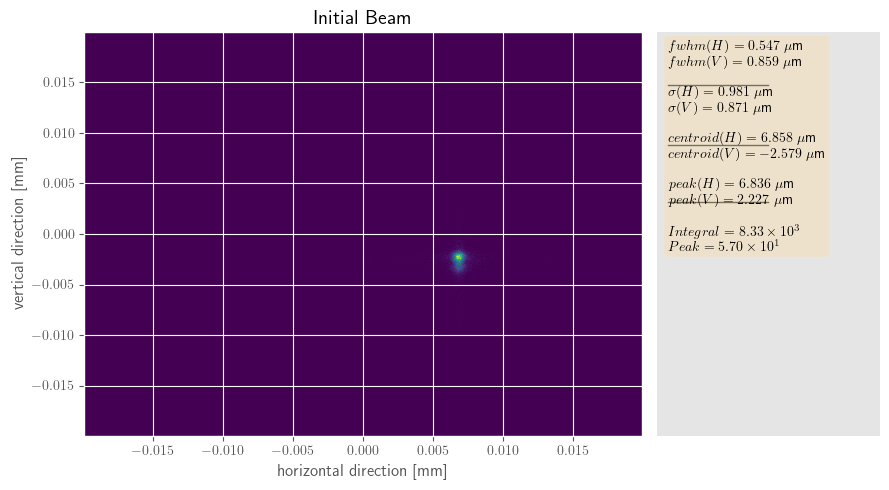

In [157]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [158]:
hist_pert.data_2D.max()

33.359841862283254

In [159]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 9.887e-04
Perturbed beam system peak_distance: 7.180e-03


In [160]:
opt_params = OptimizationParameters()

In [161]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    dump_directory=save_dir
    )

In [162]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [163]:
attribs_init

{'fwhm': 0.000988694176333902, 'peak_distance': 0.007179976132706527}

In [164]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}#, "peak_distance": attribs_init["peak_distance"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-08-10 11:30:20,702] A new study created in memory with name: no-name-4391dbf5-7500-47eb-935f-219feb56a664


In [165]:
for ix in range(5):
    opt_trial.trials(10, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])
    joblib.dump(opt_trial.study.trials, 
                save_dir /"trials.joblib", compress=4)

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline34IDC/optimization/optuna_botorch.py:316: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'hb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

Pruning trial with parameters [-19.7, -15.8, -0.0095, 0.006249999999999999, 0.0, 0.0, 0.0, 0.0]


[I 2023-08-10 11:31:08,187] Trial 5 finished with values: [0.0010972756374143628, 0.016599156822483703] and parameters: {'hb_trans': 12.300000000000004, 'vb_trans': 14.800000000000004, 'hb_pitch': 0.0185, 'vb_pitch': 0.008, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-08-10 11:31:12,652] Trial 6 finished with values: [0.0010972756374143628, 0.0032035492406745913] and parameters: {'hb_trans': 5.600000000000001, 'vb_trans': 8.600000000000001, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.00775, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-08-10 11:31:19,131] Trial 7 finished with values: [0.0010972756374143628, 0.01704671594980869] and parameters: {'hb_trans': -2.5, 'vb_trans': 9.100000000000001, 'hb_pitch': 0.0185, 'vb_pitch': 0.006249999999999999, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-08-10 11:31:24,892] Trial 8 pruned. 


Pruning trial with parameters [11.600000000000001, -13.2, -0.02, 0.0115, 0.0, 0.0, 0.0, 0.0]


[I 2023-08-10 11:31:29,309] Trial 9 pruned. 


Pruning trial with parameters [16.1, -19.1, -0.0007500000000000007, 0.0010000000000000009, 0.0, 0.0, 0.0, 0.0]


[I 2023-08-10 11:31:35,633] Trial 10 pruned. 


Pruning trial with parameters [3.8000000000000007, -18.0, 0.015000000000000003, 0.008, 0.0, 0.0, 0.0, 0.0]


[I 2023-08-10 11:31:41,693] Trial 11 finished with values: [0.0010160474632171185, 0.009928872351874084] and parameters: {'hb_trans': 12.700000000000003, 'vb_trans': 0.0, 'hb_pitch': 0.0115, 'vb_pitch': -0.0165, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-08-10 11:31:46,074] Trial 12 finished with values: [0.0011809947873485211, 0.021950862672924072] and parameters: {'hb_trans': -11.299999999999999, 'vb_trans': -9.7, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0024999999999999988, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-08-10 11:31:51,054] Trial 13 finished with values: [0.0012667111104564409, 0.021542031344703238] and parameters: {'hb_trans': 8.3, 'vb_trans': -12.899999999999999, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.01475, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputData

In [166]:
for ix in range(10):
    opt_trial.trials(10)
    joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:37:02,356] Trial 50 finished with values: [0.0012246031449204612, 0.0011096990407581551] and parameters: {'hb_trans': 5.800000000000001, 'vb_trans': 1.3000000000000007, 'hb_pitch': -0.00775, 'vb_pitch': -0.0007500000000000007, 'hb_1': -6.895499999999998, 'hb_2': -7.110199999999999, 'vb_1': -5.907, 'vb_2': -13.1796}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:37:11,456] Trial 51 finished with values: [0.001532456526023101, 0.0010836104014244224] and parameters: {'hb_trans': 4.600000000000001, 'vb_trans': 9.200000000000003, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0165, 'hb_1': -3.542099999999998, 'hb_2': -16.6059, 'vb_1': -4.6889, 'vb_2': 12.333300000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:37:20,239] Trial 52 finished with values: [0.0006905339660025467, 0.003659992877974122] and parameters: {'hb_trans': 7.400000000000002, 'vb_trans': 2.6000000000000014, 'hb_pitch': 0.006249999999999999, 'vb_pitch': -0.0095, 'hb_1': 3.179700000000004, 'hb_2': 1.644000000000002, 'vb_1': -7.1172, 'vb_2': -18.5305}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:37:29,682] Trial 53 finished with values: [0.0008693600495491393, 0.003630560720554042] and parameters: {'hb_trans': 6.200000000000003, 'vb_trans': -0.29999999999999716, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.0115, 'hb_1': 12.862900000000003, 'hb_2': 1.559700000000003, 'vb_1': -11.4128, 'vb_2': -26.4613}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:37:40,651] Trial 54 finished with values: [0.00207275246843681, 0.004951301889010421] and parameters: {'hb_trans': 7.0, 'vb_trans': 0.8000000000000007, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.0115, 'hb_1': 5.756500000000003, 'hb_2': 8.398200000000003, 'vb_1': -16.225499999999997, 'vb_2': -4.9604}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:37:50,368] Trial 55 finished with values: [0.0008400708268597032, 0.0034445464997571538] and parameters: {'hb_trans': 1.8000000000000007, 'vb_trans': -2.8999999999999986, 'hb_pitch': -0.006, 'vb_pitch': 0.009750000000000002, 'hb_1': -9.636599999999998, 'hb_2': 12.683600000000006, 'vb_1': -6.845499999999998, 'vb_2': -27.171599999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:38:01,683] Trial 56 finished with values: [0.0013327484437458345, 0.0038800697387248295] and parameters: {'hb_trans': 5.600000000000001, 'vb_trans': -1.8000000000000007, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.015000000000000003, 'hb_1': 18.791000000000004, 'hb_2': 11.427900000000001, 'vb_1': -2.0116999999999976, 'vb_2': -22.5722}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:38:12,170] Trial 57 finished with values: [0.0009328600182883022, 0.0010363762342183167] and parameters: {'hb_trans': 4.100000000000001, 'vb_trans': -2.8999999999999986, 'hb_pitch': -0.01475, 'vb_pitch': 0.0115, 'hb_1': -11.339199999999998, 'hb_2': 2.4581000000000017, 'vb_1': -1.450999999999997, 'vb_2': -27.6297}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:38:22,138] Trial 58 finished with values: [0.0008693600495491393, 0.0019704432396465883] and parameters: {'hb_trans': 1.7000000000000028, 'vb_trans': -0.5, 'hb_pitch': -0.01475, 'vb_pitch': 0.002749999999999999, 'hb_1': -2.235099999999999, 'hb_2': 2.7813000000000017, 'vb_1': -0.7236999999999973, 'vb_2': -23.1555}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:38:34,343] Trial 59 finished with values: [0.0017054930856029756, 0.0017917327277254657] and parameters: {'hb_trans': 9.700000000000003, 'vb_trans': -1.8000000000000007, 'hb_pitch': 0.0185, 'vb_pitch': 0.009750000000000002, 'hb_1': -17.874200000000002, 'hb_2': -3.7273999999999994, 'vb_1': -0.22579999999999956, 'vb_2': -20.2753}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:38:45,515] Trial 60 finished with values: [0.0008802615418614006, 0.004525105486741462] and parameters: {'hb_trans': 6.0, 'vb_trans': 4.900000000000002, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.002749999999999999, 'hb_1': -8.082799999999999, 'hb_2': 1.691200000000002, 'vb_1': -5.448699999999999, 'vb_2': -24.8374}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:38:54,847] Trial 61 finished with values: [0.0013982247132107006, 0.0005535050805055966] and parameters: {'hb_trans': 5.700000000000003, 'vb_trans': 2.0, 'hb_pitch': -0.006, 'vb_pitch': -0.0007500000000000007, 'hb_1': -4.1083, 'hb_2': 6.605000000000004, 'vb_1': 6.159800000000004, 'vb_2': -13.6589}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:39:04,973] Trial 62 finished with values: [0.0008315130061488209, 0.0023050288577973] and parameters: {'hb_trans': 5.600000000000001, 'vb_trans': -3.3000000000000007, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.006249999999999999, 'hb_1': 13.098600000000005, 'hb_2': -2.2581999999999987, 'vb_1': -5.600299999999997, 'vb_2': -24.860599999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:39:16,275] Trial 63 finished with values: [0.0008315130061488209, 0.0048702230279442996] and parameters: {'hb_trans': 14.100000000000001, 'vb_trans': 4.700000000000003, 'hb_pitch': 0.015000000000000003, 'vb_pitch': -0.01475, 'hb_1': 6.259, 'hb_2': -13.4543, 'vb_1': -7.631799999999998, 'vb_2': -27.673000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:39:26,530] Trial 64 finished with values: [0.0008693600495491393, 0.0027100709085231766] and parameters: {'hb_trans': 7.200000000000003, 'vb_trans': 11.200000000000003, 'hb_pitch': -0.0095, 'vb_pitch': -0.02, 'hb_1': -1.6701999999999977, 'hb_2': 11.6783, 'vb_1': -3.1956999999999987, 'vb_2': -19.3709}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:39:37,587] Trial 65 finished with values: [0.0008008407942801818, 0.005627004478191128] and parameters: {'hb_trans': 10.400000000000002, 'vb_trans': 1.4000000000000021, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0095, 'hb_1': 2.0585999999999984, 'hb_2': -8.3003, 'vb_1': -6.517599999999998, 'vb_2': -22.036}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:39:48,415] Trial 66 finished with values: [0.0008315130061488209, 0.0031121945273393462] and parameters: {'hb_trans': 7.800000000000001, 'vb_trans': 3.3000000000000007, 'hb_pitch': 0.0115, 'vb_pitch': 0.0010000000000000009, 'hb_1': 8.592500000000001, 'hb_2': 4.323700000000002, 'vb_1': -10.7458, 'vb_2': -24.5589}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:39:59,078] Trial 67 finished with values: [0.0009003461384075852, 0.006347374543027813] and parameters: {'hb_trans': 8.600000000000001, 'vb_trans': -1.5, 'hb_pitch': -0.01825, 'vb_pitch': 0.0115, 'hb_1': 6.237200000000001, 'hb_2': -20.1988, 'vb_1': -11.5201, 'vb_2': -24.0734}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:40:09,965] Trial 68 finished with values: [0.0009328600182883022, 0.005592152799044072] and parameters: {'hb_trans': 8.400000000000002, 'vb_trans': 12.0, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.0095, 'hb_1': 4.564, 'hb_2': -16.9048, 'vb_1': -2.654399999999999, 'vb_2': -28.7148}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/li

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:40:21,837] Trial 69 finished with values: [0.0012667111104564409, 0.004910201504179387] and parameters: {'hb_trans': 9.200000000000003, 'vb_trans': 8.8, 'hb_pitch': -0.01125, 'vb_pitch': -0.01475, 'hb_1': 6.886200000000002, 'hb_2': -27.5543, 'vb_1': 2.736000000000004, 'vb_2': -28.6018}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:40:34,799] Trial 70 finished with values: [0.0009630411583651221, 0.0034912963003113015] and parameters: {'hb_trans': 7.800000000000001, 'vb_trans': 11.0, 'hb_pitch': 0.015000000000000003, 'vb_pitch': -0.01475, 'hb_1': 2.6561999999999983, 'hb_2': 5.277100000000004, 'vb_1': -0.8780999999999999, 'vb_2': -21.0593}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:40:46,486] Trial 71 finished with values: [0.0016522387027041088, 0.0033915342175415064] and parameters: {'hb_trans': 6.5, 'vb_trans': 2.3000000000000007, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.0095, 'hb_1': -10.9785, 'hb_2': -11.432299999999998, 'vb_1': -11.572299999999998, 'vb_2': -28.8446}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:40:59,004] Trial 72 finished with values: [0.001114522676808037, 0.00566711343612213] and parameters: {'hb_trans': 9.200000000000003, 'vb_trans': 4.700000000000003, 'hb_pitch': 0.016749999999999998, 'vb_pitch': -0.01825, 'hb_1': 11.473400000000005, 'hb_2': 13.454100000000004, 'vb_1': -7.085899999999999, 'vb_2': -21.886899999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Content

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:41:10,418] Trial 73 finished with values: [0.0010066175843793975, 0.004420631045004725] and parameters: {'hb_trans': 0.40000000000000213, 'vb_trans': 10.0, 'hb_pitch': -0.0095, 'vb_pitch': -0.01475, 'hb_1': 3.3536, 'hb_2': 12.732700000000001, 'vb_1': -12.424199999999999, 'vb_2': -26.5732}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/l

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:41:19,630] Trial 74 finished with values: [0.0008693600495491393, 0.00042707167198573957] and parameters: {'hb_trans': 4.200000000000003, 'vb_trans': 1.6000000000000014, 'hb_pitch': -0.01125, 'vb_pitch': 0.0010000000000000009, 'hb_1': -8.5624, 'hb_2': 14.1177, 'vb_1': -4.4163, 'vb_2': -22.1331}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:41:32,068] Trial 75 finished with values: [0.0010160474632171185, 0.0039045711724399914] and parameters: {'hb_trans': 0.5, 'vb_trans': 2.900000000000002, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.0010000000000000009, 'hb_1': 1.5732, 'hb_2': -6.049599999999998, 'vb_1': -2.400199999999998, 'vb_2': -24.5324}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:41:42,819] Trial 76 finished with values: [0.0008638577154763496, 0.001841603727113877] and parameters: {'hb_trans': 5.800000000000001, 'vb_trans': -1.5, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.0045000000000000005, 'hb_1': 7.197700000000005, 'hb_2': -9.6022, 'vb_1': -3.4670999999999985, 'vb_2': -6.369799999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:41:51,928] Trial 77 finished with values: [0.0012246031449204612, 0.0020417514186577227] and parameters: {'hb_trans': 7.800000000000001, 'vb_trans': 7.600000000000001, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0165, 'hb_1': -18.2474, 'hb_2': 1.4486000000000026, 'vb_1': -9.712499999999999, 'vb_2': -25.2532}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:42:04,325] Trial 78 finished with values: [0.001576173085114292, 0.0034431618965458464] and parameters: {'hb_trans': 11.8, 'vb_trans': -0.29999999999999716, 'hb_pitch': 0.015000000000000003, 'vb_pitch': -0.0024999999999999988, 'hb_1': -19.1532, 'hb_2': 11.912300000000002, 'vb_1': -6.447499999999998, 'vb_2': -19.4658}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:42:18,300] Trial 79 finished with values: [0.001114522676808037, 0.003546851607594254] and parameters: {'hb_trans': 11.700000000000003, 'vb_trans': -3.3000000000000007, 'hb_pitch': 0.016749999999999998, 'vb_pitch': 0.0185, 'hb_1': 15.579300000000003, 'hb_2': -4.432299999999998, 'vb_1': -8.1389, 'vb_2': -26.5918}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:42:29,319] Trial 80 finished with values: [0.0012779543289358902, 0.005083404144460958] and parameters: {'hb_trans': 3.6000000000000014, 'vb_trans': 8.100000000000001, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.02, 'hb_1': 13.453000000000003, 'hb_2': -18.955, 'vb_1': -0.13619999999999877, 'vb_2': -18.125700000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:42:40,029] Trial 81 finished with values: [0.0013982247132107006, 0.0038424042617694796] and parameters: {'hb_trans': 1.5, 'vb_trans': 10.700000000000003, 'hb_pitch': -0.01125, 'vb_pitch': -0.013000000000000001, 'hb_1': 0.005200000000002092, 'hb_2': -14.516599999999999, 'vb_1': -4.700899999999997, 'vb_2': -14.6207}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:42:52,266] Trial 82 finished with values: [0.0010381001770249567, 0.002548669101241288] and parameters: {'hb_trans': 10.3, 'vb_trans': -2.6999999999999993, 'hb_pitch': 0.0115, 'vb_pitch': 0.0045000000000000005, 'hb_1': 1.7212000000000032, 'hb_2': -21.5285, 'vb_1': 2.122399999999999, 'vb_2': -15.411499999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:43:02,722] Trial 83 finished with values: [0.0015579156380415213, 0.001747269271004188] and parameters: {'hb_trans': 8.900000000000002, 'vb_trans': -1.3000000000000007, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.008, 'hb_1': 15.2177, 'hb_2': -5.029899999999998, 'vb_1': 6.414200000000001, 'vb_2': -3.3429}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:43:15,757] Trial 84 finished with values: [0.0009082556268427666, 0.006498452956155354] and parameters: {'hb_trans': 14.399999999999999, 'vb_trans': 2.700000000000003, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.0045000000000000005, 'hb_1': 8.602000000000004, 'hb_2': -20.6774, 'vb_1': -7.944399999999998, 'vb_2': -27.6206}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:43:24,969] Trial 85 finished with values: [0.0016601562500001416, 0.0033032145362635783] and parameters: {'hb_trans': 8.0, 'vb_trans': -1.3999999999999986, 'hb_pitch': -0.00775, 'vb_pitch': 0.008, 'hb_1': -17.0741, 'hb_2': 11.0901, 'vb_1': 11.4677, 'vb_2': -24.1285}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:43:36,666] Trial 86 finished with values: [0.0011134525635734718, 0.001930101110942614] and parameters: {'hb_trans': 4.0, 'vb_trans': 10.8, 'hb_pitch': -0.01825, 'vb_pitch': -0.02, 'hb_1': -18.1164, 'hb_2': 17.3438, 'vb_1': -4.694199999999999, 'vb_2': 26.328700000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:43:49,125] Trial 87 finished with values: [0.0010054326309558476, 0.0021027297851693837] and parameters: {'hb_trans': 4.100000000000001, 'vb_trans': 4.0, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.006, 'hb_1': 2.200400000000002, 'hb_2': 20.246000000000002, 'vb_1': -4.597799999999999, 'vb_2': -18.261400000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:44:00,790] Trial 88 finished with values: [0.0007258822630527232, 0.0018351191868130991] and parameters: {'hb_trans': 5.100000000000001, 'vb_trans': 5.700000000000003, 'hb_pitch': -0.00775, 'vb_pitch': -0.013000000000000001, 'hb_1': 0.9869000000000021, 'hb_2': 0.975200000000001, 'vb_1': -9.5471, 'vb_2': -20.9498}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:44:13,856] Trial 89 finished with values: [0.0007258822630527232, 0.004521943104092035] and parameters: {'hb_trans': 12.5, 'vb_trans': 8.900000000000002, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.01475, 'hb_1': 1.7100000000000009, 'hb_2': 8.682000000000002, 'vb_1': -4.299099999999999, 'vb_2': -12.363399999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:44:26,140] Trial 90 finished with values: [0.0009212872199274813, 0.0046158722167550445] and parameters: {'hb_trans': 11.700000000000003, 'vb_trans': -4.6, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.013250000000000001, 'hb_1': 10.893300000000004, 'hb_2': -13.375499999999999, 'vb_1': -8.220399999999998, 'vb_2': -25.767}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:44:37,033] Trial 91 finished with values: [0.0011134525635734718, 0.003227276813050247] and parameters: {'hb_trans': 2.8000000000000007, 'vb_trans': 8.8, 'hb_pitch': -0.02, 'vb_pitch': -0.0095, 'hb_1': -21.1752, 'hb_2': 15.896, 'vb_1': -12.749299999999998, 'vb_2': -15.4428}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/si

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:44:49,179] Trial 92 finished with values: [0.0007627196949128243, 0.0034673126266889023] and parameters: {'hb_trans': 1.1000000000000014, 'vb_trans': 7.700000000000003, 'hb_pitch': -0.01125, 'vb_pitch': -0.0095, 'hb_1': -29.0364, 'hb_2': 8.955400000000004, 'vb_1': -7.1785, 'vb_2': 21.5077}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:45:02,489] Trial 93 finished with values: [0.0015254393898256485, 0.0017540786080748106] and parameters: {'hb_trans': 3.6000000000000014, 'vb_trans': 7.900000000000002, 'hb_pitch': -0.01475, 'vb_pitch': -0.0165, 'hb_1': 2.0010000000000048, 'hb_2': 28.723100000000002, 'vb_1': 4.495899999999999, 'vb_2': -29.5431}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:45:15,038] Trial 94 pruned. 


Pruning trial with parameters [12.700000000000003, -7.899999999999999, 0.006249999999999999, 0.0185, -5.349599999999999, 10.127600000000001, -4.642499999999998, -29.3674]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:45:26,504] Trial 95 finished with values: [0.0007627196949128243, 0.004008815825694767] and parameters: {'hb_trans': 4.100000000000001, 'vb_trans': 0.7000000000000028, 'hb_pitch': -0.00425, 'vb_pitch': 0.009750000000000002, 'hb_1': -3.8907999999999987, 'hb_2': 12.965200000000003, 'vb_1': -6.096399999999999, 'vb_2': -19.6122}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:45:39,213] Trial 96 finished with values: [0.0010066175843793975, 0.003957940466943403] and parameters: {'hb_trans': 6.600000000000001, 'vb_trans': -2.8000000000000007, 'hb_pitch': -0.0165, 'vb_pitch': 0.013250000000000001, 'hb_1': -15.5331, 'hb_2': 6.684699999999999, 'vb_1': -3.430299999999999, 'vb_2': -2.7872999999999983}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:45:50,466] Trial 97 pruned. 


Pruning trial with parameters [-16.3, 13.700000000000003, -0.006, -0.01825, -19.1428, 15.592100000000002, -11.518899999999999, -0.9105999999999987]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:46:03,601] Trial 98 finished with values: [0.0008693600495491393, 0.001808948589144796] and parameters: {'hb_trans': 11.8, 'vb_trans': 2.200000000000003, 'hb_pitch': 0.015000000000000003, 'vb_pitch': 0.002749999999999999, 'hb_1': 7.6738, 'hb_2': 9.428800000000003, 'vb_1': -4.692599999999999, 'vb_2': -29.8942}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:46:15,492] Trial 99 finished with values: [0.0007948642869189987, 0.00328947217840863] and parameters: {'hb_trans': 7.900000000000002, 'vb_trans': -1.0, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.0007500000000000007, 'hb_1': -2.4559999999999995, 'hb_2': 9.1419, 'vb_1': -7.098399999999998, 'vb_2': -8.619}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:46:26,208] Trial 100 finished with values: [0.000969210607484419, 0.003135092649900782] and parameters: {'hb_trans': 5.900000000000002, 'vb_trans': 8.100000000000001, 'hb_pitch': -0.006, 'vb_pitch': -0.02, 'hb_1': -27.2569, 'hb_2': 3.062899999999999, 'vb_1': -0.5255999999999972, 'vb_2': 12.990900000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:46:38,737] Trial 101 finished with values: [0.0011523851290241164, 0.0017540786080748102] and parameters: {'hb_trans': 4.5, 'vb_trans': 11.5, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.01825, 'hb_1': -29.5795, 'hb_2': 12.293700000000001, 'vb_1': -12.2711, 'vb_2': 11.999600000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:46:50,615] Trial 102 finished with values: [0.0009328600182883022, 0.0016833314624939652] and parameters: {'hb_trans': 7.100000000000001, 'vb_trans': -3.099999999999998, 'hb_pitch': -0.006, 'vb_pitch': 0.009750000000000002, 'hb_1': 4.2450000000000045, 'hb_2': 16.3046, 'vb_1': -2.2561, 'vb_2': -12.026499999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:47:03,593] Trial 103 finished with values: [0.0010018693617521942, 0.0006809729336416663] and parameters: {'hb_trans': 2.900000000000002, 'vb_trans': 11.0, 'hb_pitch': -0.01825, 'vb_pitch': -0.02, 'hb_1': -29.6737, 'hb_2': 11.539700000000003, 'vb_1': -2.5691999999999986, 'vb_2': 2.551400000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:47:15,744] Trial 104 finished with values: [0.0008315130061488209, 0.005182341251104128] and parameters: {'hb_trans': 1.9000000000000021, 'vb_trans': 4.300000000000001, 'hb_pitch': -0.0165, 'vb_pitch': -0.0165, 'hb_1': -25.4865, 'hb_2': 1.7606000000000002, 'vb_1': -8.4849, 'vb_2': 16.126200000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:47:27,650] Trial 105 pruned. 


Pruning trial with parameters [4.900000000000002, -9.899999999999999, -0.02, 0.015000000000000003, -0.5842999999999989, 11.719100000000005, 1.0747999999999998, -23.7292]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:47:38,619] Trial 106 finished with values: [0.0008638577154763496, 0.004588934625721476] and parameters: {'hb_trans': 8.600000000000001, 'vb_trans': 10.700000000000003, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.0095, 'hb_1': 5.8733, 'hb_2': 4.748600000000003, 'vb_1': -4.113999999999997, 'vb_2': -11.2287}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:47:50,464] Trial 107 pruned. 


Pruning trial with parameters [3.900000000000002, -11.4, -0.0007500000000000007, 0.015000000000000003, 7.238399999999999, -11.096799999999998, -4.730699999999999, -28.9405]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:48:01,488] Trial 108 finished with values: [0.0008693600495491393, 0.004530897455641656] and parameters: {'hb_trans': -0.8999999999999986, 'vb_trans': 9.700000000000003, 'hb_pitch': -0.01475, 'vb_pitch': -0.01475, 'hb_1': -25.3656, 'hb_2': -1.563799999999997, 'vb_1': -5.540599999999998, 'vb_2': 16.866600000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:48:11,527] Trial 109 finished with values: [0.0008008407942801818, 0.0038794552202321047] and parameters: {'hb_trans': 2.5, 'vb_trans': 12.899999999999999, 'hb_pitch': -0.00425, 'vb_pitch': -0.02, 'hb_1': 1.5602000000000018, 'hb_2': 2.6912999999999982, 'vb_1': -5.010999999999999, 'vb_2': -0.9697999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:48:23,716] Trial 110 finished with values: [0.0009328600182883022, 0.003855412599720932] and parameters: {'hb_trans': 4.900000000000002, 'vb_trans': 11.5, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.013000000000000001, 'hb_1': -9.404499999999999, 'hb_2': 11.561399999999999, 'vb_1': -3.7012, 'vb_2': -10.3856}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:48:38,342] Trial 111 finished with values: [0.0007595873626028013, 0.004586336134785081] and parameters: {'hb_trans': 7.5, 'vb_trans': -1.5, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.015000000000000003, 'hb_1': 0.947300000000002, 'hb_2': 14.0518, 'vb_1': -8.023599999999998, 'vb_2': -23.7576}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:48:48,162] Trial 112 finished with values: [0.001242961138804584, 0.0002949962395897115] and parameters: {'hb_trans': 3.5, 'vb_trans': 9.8, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0165, 'hb_1': -21.7631, 'hb_2': 15.723800000000004, 'vb_1': -0.7137999999999991, 'vb_2': -16.988599999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:49:00,247] Trial 113 finished with values: [0.0009392277373863762, 0.0017239163519443092] and parameters: {'hb_trans': 1.7000000000000028, 'vb_trans': 2.400000000000002, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0007500000000000007, 'hb_1': -28.775, 'hb_2': 14.479300000000002, 'vb_1': -6.953299999999999, 'vb_2': 18.9555}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:49:11,551] Trial 114 finished with values: [0.0016260572075535284, 0.0029815158429566915] and parameters: {'hb_trans': 3.900000000000002, 'vb_trans': -2.5, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.0115, 'hb_1': -0.31899999999999906, 'hb_2': -15.5214, 'vb_1': 7.1008, 'vb_2': -23.8634}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:49:27,188] Trial 115 finished with values: [0.002844212085783582, 0.002557074408745345] and parameters: {'hb_trans': 9.900000000000002, 'vb_trans': 0.40000000000000213, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.0010000000000000009, 'hb_1': 4.591799999999999, 'hb_2': 14.154200000000003, 'vb_1': 23.4771, 'vb_2': -21.0094}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:49:39,571] Trial 116 finished with values: [0.0012128654637085234, 0.0018467749657302187] and parameters: {'hb_trans': 4.900000000000002, 'vb_trans': 2.3000000000000007, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.0010000000000000009, 'hb_1': -18.4241, 'hb_2': 18.9615, 'vb_1': -0.02459999999999951, 'vb_2': 8.396300000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:49:50,990] Trial 117 finished with values: [0.0009630411583651221, 0.0020265142548288226] and parameters: {'hb_trans': 10.0, 'vb_trans': 9.3, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.0165, 'hb_1': -4.531199999999998, 'hb_2': -1.9507999999999974, 'vb_1': -9.291, 'vb_2': -7.3887}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:50:04,717] Trial 118 finished with values: [0.0010160474632171185, 0.0023225460925830623] and parameters: {'hb_trans': 1.5, 'vb_trans': 7.0, 'hb_pitch': -0.02, 'vb_pitch': -0.0165, 'hb_1': -20.5264, 'hb_2': 13.5278, 'vb_1': -6.4289999999999985, 'vb_2': -1.7953999999999972}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/sit

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:50:15,173] Trial 119 finished with values: [0.0008693600495491393, 0.0023174077099774007] and parameters: {'hb_trans': 7.300000000000001, 'vb_trans': -0.5, 'hb_pitch': -0.00775, 'vb_pitch': 0.006249999999999999, 'hb_1': 0.4991000000000021, 'hb_2': 7.1036, 'vb_1': -0.3841999999999999, 'vb_2': -18.259999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:50:27,224] Trial 120 finished with values: [0.0009379576519677824, 0.004053175568982075] and parameters: {'hb_trans': 0.6000000000000014, 'vb_trans': 12.0, 'hb_pitch': -0.01825, 'vb_pitch': -0.01475, 'hb_1': 1.4350000000000023, 'hb_2': 12.1845, 'vb_1': -9.4617, 'vb_2': -4.0894999999999975}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:50:38,507] Trial 121 finished with values: [0.0007948642869189987, 0.002195908869313365] and parameters: {'hb_trans': 0.9000000000000021, 'vb_trans': 2.3000000000000007, 'hb_pitch': -0.0165, 'vb_pitch': 0.0010000000000000009, 'hb_1': -8.2258, 'hb_2': 2.6621999999999986, 'vb_1': -6.9842999999999975, 'vb_2': -17.8414}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:50:50,913] Trial 122 finished with values: [0.0008802615418614006, 0.0016330069832217417] and parameters: {'hb_trans': 4.100000000000001, 'vb_trans': -0.5999999999999979, 'hb_pitch': -0.006, 'vb_pitch': 0.002749999999999999, 'hb_1': -12.058899999999998, 'hb_2': 2.4370000000000047, 'vb_1': -9.9377, 'vb_2': -4.410599999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:51:06,140] Trial 123 finished with values: [0.0007258822630527232, 0.0025663813527378697] and parameters: {'hb_trans': 5.300000000000001, 'vb_trans': -3.099999999999998, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.013250000000000001, 'hb_1': -3.3038999999999987, 'hb_2': 5.586500000000001, 'vb_1': -8.829899999999999, 'vb_2': -21.8448}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:51:19,090] Trial 124 finished with values: [0.0007595873626028013, 0.004469440753609385] and parameters: {'hb_trans': 9.400000000000002, 'vb_trans': 1.3000000000000007, 'hb_pitch': -0.00775, 'vb_pitch': 0.0010000000000000009, 'hb_1': 0.9006000000000007, 'hb_2': 3.1721000000000004, 'vb_1': -6.520799999999998, 'vb_2': -14.0863}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:51:32,488] Trial 125 finished with values: [0.0009480706952611941, 0.0012143388784615135] and parameters: {'hb_trans': 10.8, 'vb_trans': -2.3000000000000007, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.0115, 'hb_1': 0.38510000000000133, 'hb_2': -0.6296999999999997, 'vb_1': -1.9909999999999997, 'vb_2': 3.822800000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:51:45,276] Trial 126 finished with values: [0.0008315130061488209, 0.0031328103690960647] and parameters: {'hb_trans': 2.200000000000003, 'vb_trans': 4.800000000000001, 'hb_pitch': -0.0165, 'vb_pitch': -0.013000000000000001, 'hb_1': 1.3317000000000014, 'hb_2': 8.124300000000005, 'vb_1': -3.1529999999999987, 'vb_2': 7.8700000000000045}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:52:03,119] Trial 127 finished with values: [0.0008008407942801818, 0.004084816306570328] and parameters: {'hb_trans': 9.600000000000001, 'vb_trans': -1.6999999999999993, 'hb_pitch': 0.016749999999999998, 'vb_pitch': -0.0007500000000000007, 'hb_1': 3.6225000000000023, 'hb_2': -12.4681, 'vb_1': -4.7331, 'vb_2': -22.0373}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:52:19,212] Trial 128 finished with values: [0.0008638577154763496, 0.0007880865425570789] and parameters: {'hb_trans': 4.700000000000003, 'vb_trans': 5.900000000000002, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0095, 'hb_1': 12.4981, 'hb_2': -0.7676999999999978, 'vb_1': -5.142799999999998, 'vb_2': -15.377199999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:52:34,627] Trial 129 finished with values: [0.0009003461384075852, 0.004937317856917787] and parameters: {'hb_trans': 3.900000000000002, 'vb_trans': 13.800000000000004, 'hb_pitch': -0.02, 'vb_pitch': -0.0165, 'hb_1': -9.472099999999998, 'hb_2': 3.357199999999999, 'vb_1': -10.0058, 'vb_2': -24.7851}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:52:49,589] Trial 130 finished with values: [0.0010719969921924816, 0.0008293597534894065] and parameters: {'hb_trans': 9.400000000000002, 'vb_trans': -2.1999999999999993, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.009750000000000002, 'hb_1': 15.201, 'hb_2': -18.741999999999997, 'vb_1': -3.9223, 'vb_2': -18.424799999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:53:03,000] Trial 131 finished with values: [0.0007627196949128243, 0.0023963120576546634] and parameters: {'hb_trans': 7.900000000000002, 'vb_trans': 2.5, 'hb_pitch': 0.013250000000000001, 'vb_pitch': -0.0024999999999999988, 'hb_1': 7.142000000000003, 'hb_2': 5.760200000000005, 'vb_1': -7.340199999999999, 'vb_2': -1.2759999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Conte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:53:17,252] Trial 132 finished with values: [0.0008008407942801818, 0.004861403259702117] and parameters: {'hb_trans': 6.200000000000003, 'vb_trans': 14.899999999999999, 'hb_pitch': -0.006, 'vb_pitch': -0.01825, 'hb_1': -20.944899999999997, 'hb_2': 5.5634000000000015, 'vb_1': -7.456999999999997, 'vb_2': 24.065400000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:53:32,791] Trial 133 finished with values: [0.0008693600495491393, 0.0017608616133063437] and parameters: {'hb_trans': 3.8000000000000007, 'vb_trans': 7.5, 'hb_pitch': -0.02, 'vb_pitch': -0.01125, 'hb_1': 19.518700000000003, 'hb_2': 3.9558999999999997, 'vb_1': -6.634899999999998, 'vb_2': 25.558500000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:53:48,048] Trial 134 finished with values: [0.0009765625000000833, 0.0012163006549883932] and parameters: {'hb_trans': 10.100000000000001, 'vb_trans': -0.5999999999999979, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.008, 'hb_1': 12.632800000000003, 'hb_2': -13.3549, 'vb_1': -4.518999999999998, 'vb_2': -2.907}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:54:04,699] Trial 135 finished with values: [0.0007720404443771116, 0.0038996832009784025] and parameters: {'hb_trans': 12.0, 'vb_trans': -0.09999999999999787, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.0115, 'hb_1': 7.8264, 'hb_2': -10.8677, 'vb_1': -9.2028, 'vb_2': -18.258899999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:54:17,078] Trial 136 finished with values: [0.0008008407942801818, 0.00290209171232797] and parameters: {'hb_trans': 1.1000000000000014, 'vb_trans': 2.400000000000002, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0007500000000000007, 'hb_1': 21.4705, 'hb_2': -0.7458999999999989, 'vb_1': -9.322199999999999, 'vb_2': -18.3318}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:54:33,937] Trial 137 finished with values: [0.0012732817197662507, 0.0014373228544467798] and parameters: {'hb_trans': 12.300000000000004, 'vb_trans': -2.5, 'hb_pitch': 0.015000000000000003, 'vb_pitch': 0.009750000000000002, 'hb_1': 17.568000000000005, 'hb_2': -17.1385, 'vb_1': -0.9436, 'vb_2': 22.683500000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:54:47,561] Trial 138 finished with values: [0.0007595873626028013, 0.0049392490427763785] and parameters: {'hb_trans': 7.400000000000002, 'vb_trans': 9.600000000000001, 'hb_pitch': 0.015000000000000003, 'vb_pitch': -0.0095, 'hb_1': 7.528800000000004, 'hb_2': -4.778199999999998, 'vb_1': -7.026399999999999, 'vb_2': -2.8596000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Conte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:55:03,671] Trial 139 pruned. 


Pruning trial with parameters [10.700000000000003, -7.899999999999999, 0.016749999999999998, 0.013250000000000001, -4.2696000000000005, 6.9114, -5.7318999999999996, 7.895299999999999]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:55:22,033] Trial 140 finished with values: [0.0010300304252798234, 0.003625960913269152] and parameters: {'hb_trans': 7.300000000000001, 'vb_trans': -3.599999999999998, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.016749999999999998, 'hb_1': 11.966000000000001, 'hb_2': -20.990000000000002, 'vb_1': -11.037099999999999, 'vb_2': -15.3202}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:55:39,644] Trial 141 finished with values: [0.0008734640537109298, 0.002106128596307588] and parameters: {'hb_trans': 5.0, 'vb_trans': 3.3000000000000007, 'hb_pitch': -0.0165, 'vb_pitch': -0.006, 'hb_1': 29.825200000000002, 'hb_2': -4.2216999999999985, 'vb_1': -7.261799999999997, 'vb_2': -21.6254}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:55:55,774] Trial 142 finished with values: [0.0010753279074974178, 0.0035137595419684627] and parameters: {'hb_trans': 6.800000000000001, 'vb_trans': 8.700000000000003, 'hb_pitch': -0.01475, 'vb_pitch': -0.01825, 'hb_1': 24.299800000000005, 'hb_2': -2.8318999999999974, 'vb_1': -3.730999999999998, 'vb_2': 3.174500000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:56:11,699] Trial 143 finished with values: [0.0012010130738525284, 0.0023008877740885573] and parameters: {'hb_trans': 4.200000000000003, 'vb_trans': -4.0, 'hb_pitch': -0.0165, 'vb_pitch': 0.016749999999999998, 'hb_1': 22.674, 'hb_2': -15.3616, 'vb_1': -10.143799999999999, 'vb_2': 24.3292}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:56:28,603] Trial 144 finished with values: [0.0013540453734241435, 0.0016533206009118175] and parameters: {'hb_trans': 10.5, 'vb_trans': -1.3999999999999986, 'hb_pitch': 0.016749999999999998, 'vb_pitch': 0.009750000000000002, 'hb_1': -2.3165999999999976, 'hb_2': 9.1064, 'vb_1': -1.1782000000000004, 'vb_2': 29.7164}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:56:44,125] Trial 145 finished with values: [0.00103580094900382, 0.0023713081174976712] and parameters: {'hb_trans': 2.900000000000002, 'vb_trans': 0.5, 'hb_pitch': -0.0095, 'vb_pitch': -0.0007500000000000007, 'hb_1': 21.488, 'hb_2': -5.531599999999997, 'vb_1': -14.037999999999998, 'vb_2': -20.8121}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:57:02,306] Trial 146 finished with values: [0.0009630411583651221, 0.001648988749098465] and parameters: {'hb_trans': 6.900000000000002, 'vb_trans': -2.8999999999999986, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.0115, 'hb_1': 24.765900000000002, 'hb_2': -4.962599999999998, 'vb_1': -6.7196, 'vb_2': -8.621499999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:57:18,204] Trial 147 finished with values: [0.000988694176333902, 0.0012849313834903103] and parameters: {'hb_trans': 4.700000000000003, 'vb_trans': 10.200000000000003, 'hb_pitch': -0.01125, 'vb_pitch': -0.0165, 'hb_1': -6.997399999999999, 'hb_2': 24.3046, 'vb_1': -7.7148, 'vb_2': 14.880099999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:57:35,307] Trial 148 finished with values: [0.001576173085114292, 0.0016590788093781242] and parameters: {'hb_trans': 6.700000000000003, 'vb_trans': 2.700000000000003, 'hb_pitch': -0.0095, 'vb_pitch': -0.00425, 'hb_1': 27.340400000000002, 'hb_2': -28.336, 'vb_1': -7.742899999999999, 'vb_2': -8.788499999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 11:57:51,494] Trial 149 finished with values: [0.0008638577154763496, 0.00219264923040212] and parameters: {'hb_trans': 3.200000000000003, 'vb_trans': 7.800000000000001, 'hb_pitch': -0.02, 'vb_pitch': -0.0095, 'hb_1': -4.213099999999997, 'hb_2': 9.6665, 'vb_1': -7.585799999999999, 'vb_2': 6.4191}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_60432/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes: title={'center': 'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

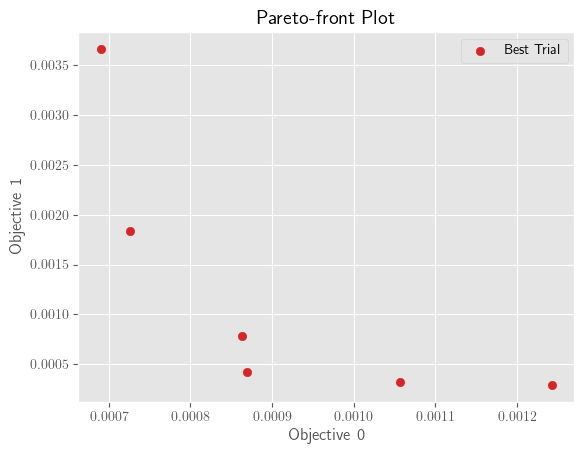

In [167]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [169]:
joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_pi/trials.joblib']

In [170]:
opt_trial.initial_motor_positions

[-5.499797801406879,
 -3.6998638964519333,
 3.0054569719342354,
 3.0037116426822412,
 212.23330000000004,
 107.48439999999998,
 146.94929999999997,
 222.10200000000003]

In [171]:
opt_trial.study.trials[0].params

{'hb_trans': 0.0,
 'vb_trans': 0.0,
 'hb_pitch': 0.0,
 'vb_pitch': 0.0,
 'hb_1': 0.0,
 'hb_2': 0.0,
 'vb_1': 0.0,
 'vb_2': 0.0}

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.000988694176333902, 0.007179976132706527]
Absolute motor values
{'hb_trans': [-6.07391980592043], 'vb_trans': [-2.569284807019581], 'hb_pitch': [3.0054569719342354], 'vb_pitch': [3.0037116426822412], 'hb_1': [212.2333000000012], 'hb_2': [107.48440000000022], 'vb_1': [146.94930000000005], 'vb_2': [222.1020000000002]}


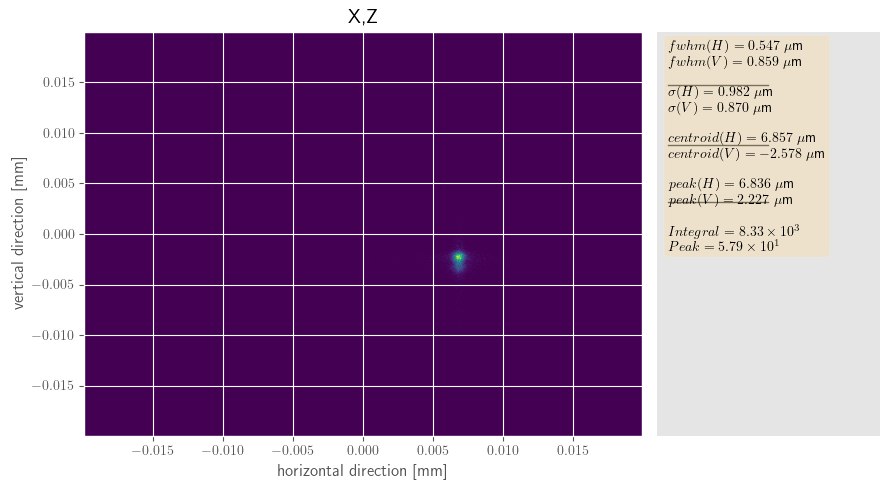

In [172]:
t = opt_trial.study.trials[0]

params = t.params
current_params = []
for mot in opt_trial.motor_types:
    current_params.append(params[mot])

opt_trial._loss_fn_this(current_params)
print(t.values)



print("Absolute motor values")
abs_motor_values = {mt: movers.get_absolute_positions(opt_trial.focusing_system, mt) for mt in opt_trial.motor_types}
print(abs_motor_values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

Trial number 37
[0.0010563138502336807, 0.00032572422031558555]
Absolute motor values
{'hb_trans': [0.8260070261739706], 'vb_trans': [-0.4692848070195813], 'hb_pitch': [3.0072023011862297], 'vb_pitch': [3.0037116426822412], 'hb_1': [212.2333000000012], 'hb_2': [107.48440000000022], 'vb_1': [146.94930000000005], 'vb_2': [222.1020000000002]}


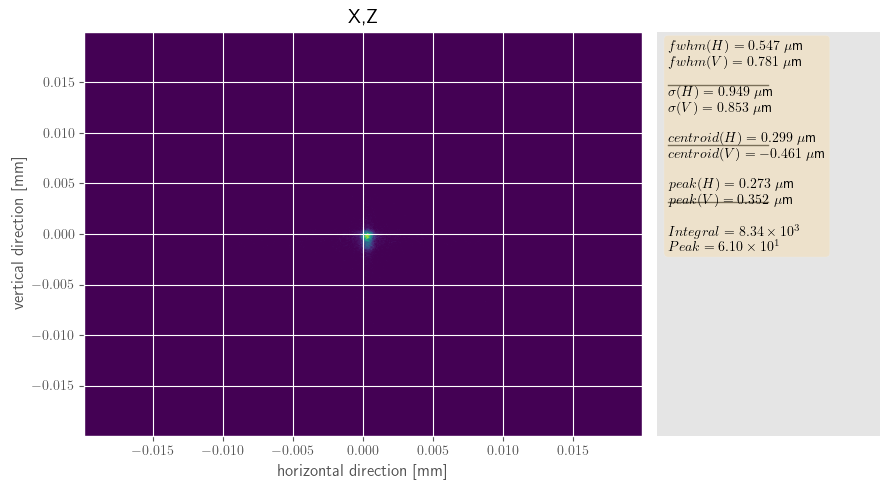

Trial number 52
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.0006905339660025467, 0.003659992877974122]
Absolute motor values
{'hb_trans': [1.3253535057395172], 'vb_trans': [0.0324072925894038], 'hb_pitch': [3.0124382889422128], 'vb_pitch': [2.9949849964222692], 'hb_1': [215.41300000000123], 'hb_2': [109.12840000000021], 'vb_1': [139.83210000000005], 'vb_2': [203.57150000000024]}


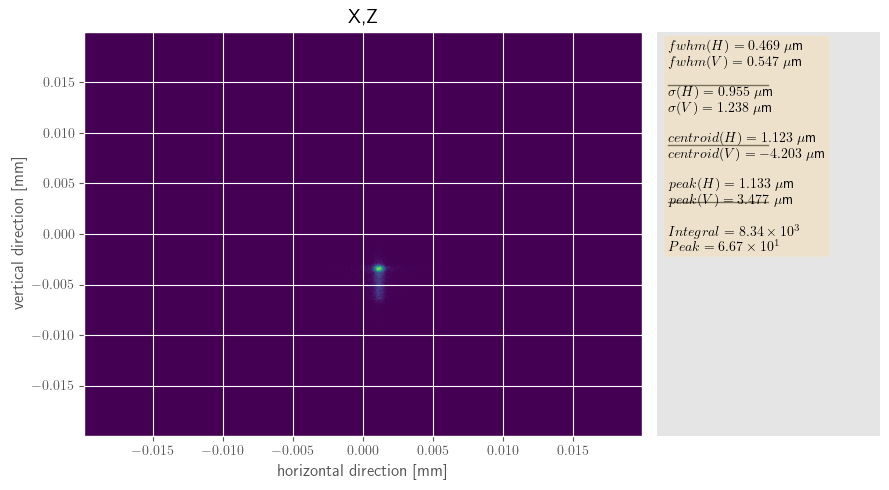

Trial number 74
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.0008693600495491393, 0.00042707167198573957]
Absolute motor values
{'hb_trans': [-1.8817831035625674], 'vb_trans': [-0.9678799084397317], 'hb_pitch': [2.9949849964222692], 'vb_pitch': [3.0054569719342354], 'hb_1': [203.6709000000012], 'hb_2': [121.60210000000023], 'vb_1': [142.53300000000002], 'vb_2': [199.96890000000027]}


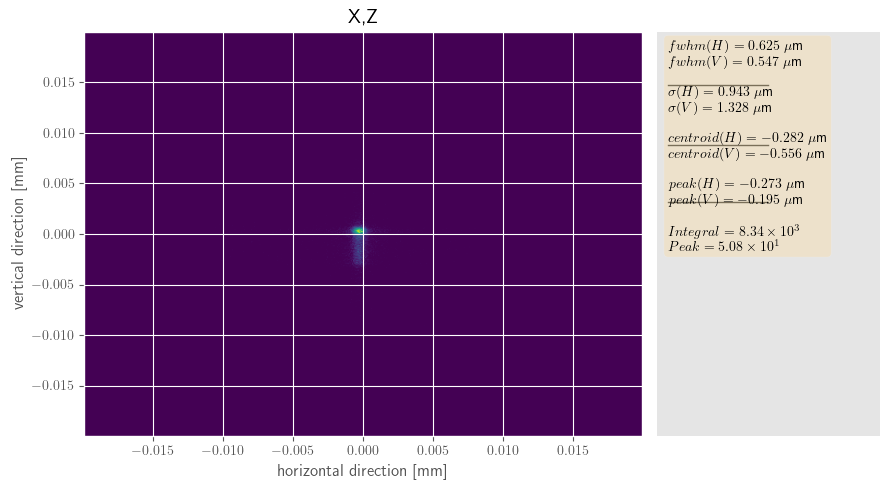

Trial number 88
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.0007258822630527232, 0.0018351191868130991]
Absolute motor values
{'hb_trans': [-0.9808729938945697], 'vb_trans': [3.142071619828837], 'hb_pitch': [2.9984756549262577], 'vb_pitch': [2.991494337918281], 'hb_1': [213.22020000000123], 'hb_2': [108.45960000000026], 'vb_1': [137.40220000000002], 'vb_2': [201.15220000000028]}


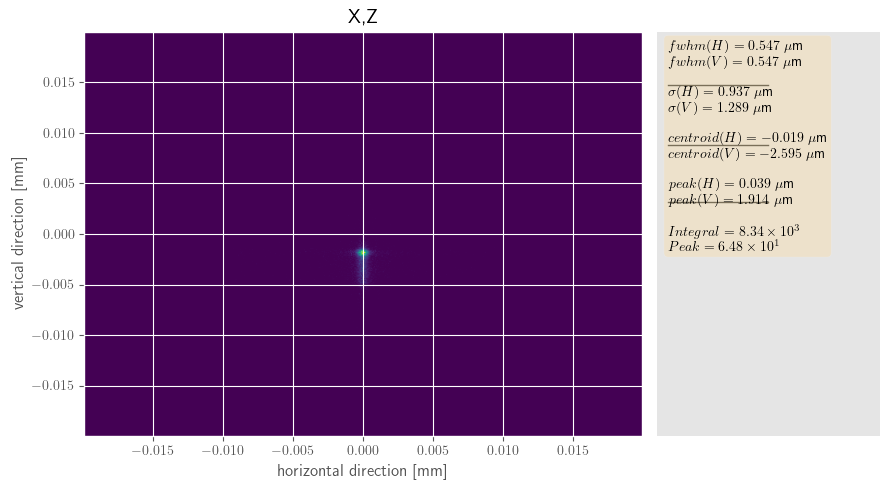

Trial number 112
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.001242961138804584, 0.0002949962395897115]
Absolute motor values
{'hb_trans': [-2.5836383545850263], 'vb_trans': [7.246968865309865], 'hb_pitch': [2.9932396671702746], 'vb_pitch': [2.988003679414292], 'hb_1': [190.4702000000012], 'hb_2': [123.20820000000026], 'vb_1': [146.23550000000003], 'vb_2': [205.11340000000024]}


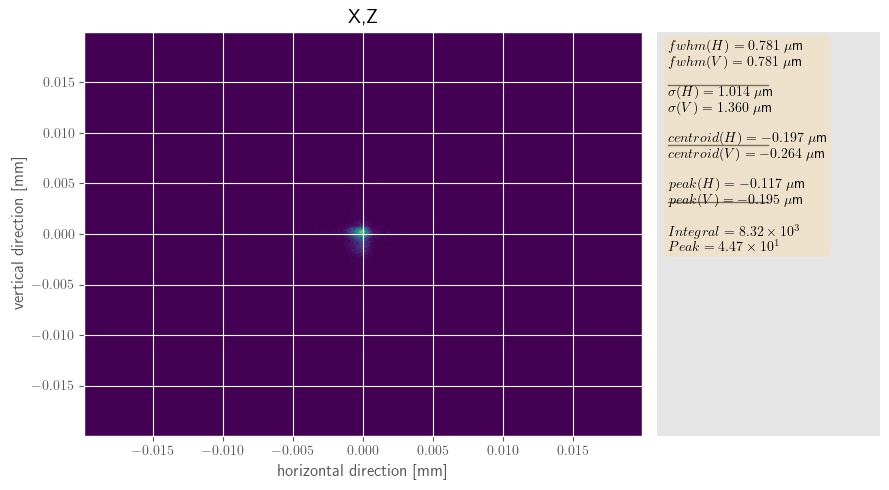

Trial number 128
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.0008638577154763496, 0.0007880865425570789]
Absolute motor values
{'hb_trans': [-1.3836383545850266], 'vb_trans': [3.341731190243893], 'hb_pitch': [2.9932396671702746], 'vb_pitch': [2.9949849964222692], 'hb_1': [224.73140000000123], 'hb_2': [106.71670000000026], 'vb_1': [141.8065], 'vb_2': [206.72480000000027]}


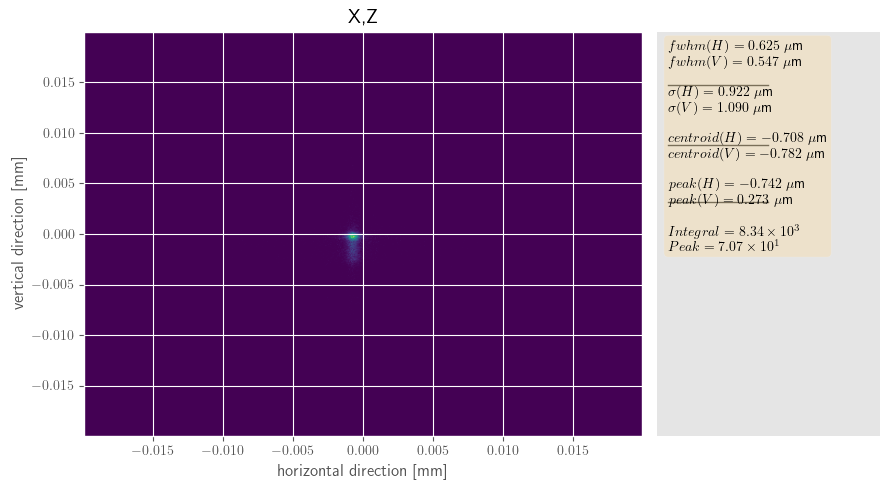

[0.00079486 0.00086593] [0.0008638577154763496, 0.00219264923040212]


In [173]:
for t in opt_trial.study.best_trials:
    print("Trial number", t.number)
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    
    
    
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    print("Absolute motor values")
    abs_motor_values = {mt: movers.get_absolute_positions(opt_trial.focusing_system, mt) for mt in opt_trial.motor_types}
    print(abs_motor_values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()

t = opt_trial.study.trials[-1]
current_params = []
for mot in opt_trial.motor_types:
    current_params.append(params[mot])
print(opt_trial._loss_fn_this(current_params), opt_trial.study.trials[-1].values)

### One step optimization

In [177]:
save_dir = Path(Path.home() / "code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_one_step")

In [178]:
!rm -r $save_dir

In [179]:
save_dir.mkdir()

In [180]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


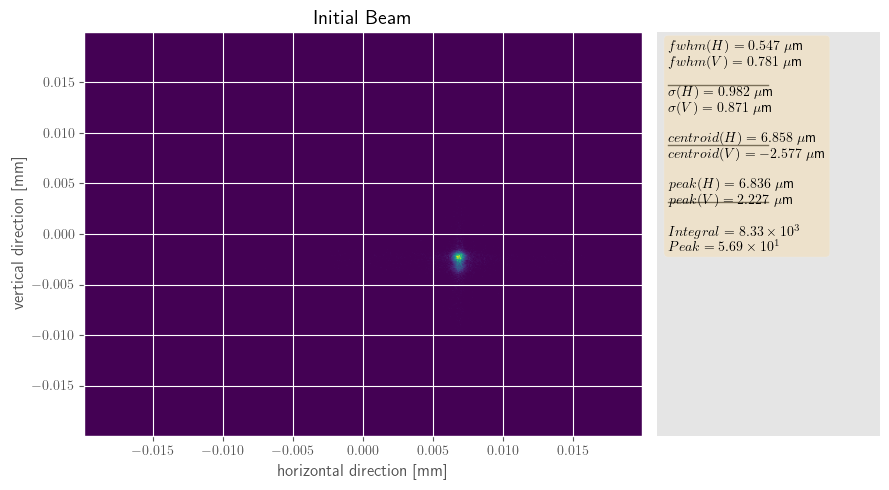

In [181]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [182]:
hist_pert.data_2D.max()

33.91207860211913

In [183]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 9.481e-04
Perturbed beam system peak_distance: 7.180e-03


In [184]:
opt_params = OptimizationParameters()

In [185]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    dump_directory=save_dir
    )

In [186]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [187]:
attribs_init

{'fwhm': 0.0009480706952611941, 'peak_distance': 0.007179976132706527}

In [188]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}#, "peak_distance": attribs_init["peak_distance"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-08-10 12:02:10,565] A new study created in memory with name: no-name-4c771738-d37e-43ad-85ae-bac7e96c1fe2


In [189]:
for i in range(15):
    opt_trial.trials(10)
    joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'hb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'vb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:02:45,249] Trial 1 finished with values: [0.0011799849583589454, 0.02035591181520118] and parameters: {'hb_trans': 17.1, 'vb_trans': -7.399999999999999, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.013000000000000001, 'hb_1': 4.063500000000005, 'hb_2': 5.732600000000005, 'vb_1': 27.870800000000003, 'vb_2': 9.190600000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:02:52,737] Trial 2 finished with values: [0.0033969779552592907, 0.013159383513901493] and parameters: {'hb_trans': 9.900000000000002, 'vb_trans': 6.100000000000001, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.0185, 'hb_1': -29.4968, 'hb_2': -23.6134, 'vb_1': -12.0778, 'vb_2': 9.384599999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:02:59,219] Trial 3 finished with values: [0.001070884384739413, 0.01664104479049799] and parameters: {'hb_trans': 12.300000000000004, 'vb_trans': 14.800000000000004, 'hb_pitch': 0.0185, 'vb_pitch': 0.008, 'hb_1': 8.548500000000004, 'hb_2': 13.047200000000004, 'vb_1': -1.9440999999999988, 'vb_2': -10.465}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:03:05,676] Trial 4 finished with values: [0.0017605230837228012, 0.017585210431802806] and parameters: {'hb_trans': -2.5, 'vb_trans': 9.100000000000001, 'hb_pitch': 0.0185, 'vb_pitch': 0.006249999999999999, 'hb_1': 17.4493, 'hb_2': -19.745199999999997, 'vb_1': -28.3891, 'vb_2': 18.022200000000005}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:03:10,579] Trial 5 pruned. 


Pruning trial with parameters [16.1, -19.1, -0.0007500000000000007, 0.0010000000000000009, 5.7819, -26.8826, 23.7053, 13.695900000000002]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:03:16,990] Trial 6 finished with values: [0.002301146810146325, 0.010286696547957023] and parameters: {'hb_trans': 12.700000000000003, 'vb_trans': 0.0, 'hb_pitch': 0.0115, 'vb_pitch': -0.0165, 'hb_1': -16.863, 'hb_2': -14.476899999999999, 'vb_1': -1.9136999999999986, 'vb_2': -2.4376999999999995}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:03:22,035] Trial 7 finished with values: [0.001943948167714461, 0.021714109295472555] and parameters: {'hb_trans': 8.3, 'vb_trans': -12.899999999999999, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.01475, 'hb_1': 16.128800000000005, 'hb_2': 25.690200000000004, 'vb_1': 6.569600000000001, 'vb_2': -20.988999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:03:29,173] Trial 8 finished with values: [0.0016666062661989714, 0.010622389977707512] and parameters: {'hb_trans': -0.5, 'vb_trans': -5.0, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.015000000000000003, 'hb_1': -6.969099999999997, 'hb_2': -11.0703, 'vb_1': 4.1036, 'vb_2': -18.731}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:03:34,875] Trial 9 finished with values: [0.0016061410354882744, 0.025136787989475835] and parameters: {'hb_trans': -15.0, 'vb_trans': 7.5, 'hb_pitch': 0.0115, 'vb_pitch': 0.002749999999999999, 'hb_1': 28.393700000000003, 'hb_2': 8.043199999999999, 'vb_1': 23.305300000000003, 'vb_2': -0.2751999999999981}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:03:39,591] Trial 10 finished with values: [0.0016016815885603636, 0.0125814170557217] and parameters: {'hb_trans': -6.0, 'vb_trans': 8.5, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.01125, 'hb_1': -15.301599999999999, 'hb_2': 17.568000000000005, 'vb_1': -0.28969999999999985, 'vb_2': 24.9056}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:03:45,606] Trial 11 finished with values: [0.0008008407942801818, 0.008107895085827042] and parameters: {'hb_trans': 0.0, 'vb_trans': -1.5999999999999979, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.0024999999999999988, 'hb_1': -16.4362, 'hb_2': -0.9847000000000001, 'vb_1': -6.003599999999999, 'vb_2': -6.421699999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:03:51,991] Trial 12 finished with values: [0.0010066175843793975, 0.01030013065070093] and parameters: {'hb_trans': -1.3000000000000007, 'vb_trans': 6.100000000000001, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.0010000000000000009, 'hb_1': 2.1811000000000007, 'hb_2': -1.000399999999999, 'vb_1': -13.1109, 'vb_2': -1.7486999999999995}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:03:58,261] Trial 13 finished with values: [0.0007948642869189987, 0.009977498965720913] and parameters: {'hb_trans': -1.8000000000000007, 'vb_trans': -2.1999999999999993, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0007500000000000007, 'hb_1': 0.5426000000000002, 'hb_2': 4.9071, 'vb_1': -9.6375, 'vb_2': 3.2343000000000046}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:04:05,302] Trial 14 finished with values: [0.0013101960805663947, 0.009752493612819792] and parameters: {'hb_trans': -1.1999999999999993, 'vb_trans': 7.600000000000001, 'hb_pitch': 0.006249999999999999, 'vb_pitch': -0.006, 'hb_1': -6.5931999999999995, 'hb_2': 8.384100000000004, 'vb_1': 4.365500000000004, 'vb_2': -1.875}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:04:11,416] Trial 15 finished with values: [0.0009082556268427666, 0.013097638265277134] and parameters: {'hb_trans': -3.6999999999999993, 'vb_trans': 6.700000000000003, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.0045000000000000005, 'hb_1': -4.125799999999998, 'hb_2': 8.229199999999999, 'vb_1': -1.8413000000000004, 'vb_2': -4.691099999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasy

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:04:18,996] Trial 16 finished with values: [0.000988694176333902, 0.015501718548901615] and parameters: {'hb_trans': -4.399999999999999, 'vb_trans': -2.599999999999998, 'hb_pitch': 0.008, 'vb_pitch': -0.00775, 'hb_1': -10.7833, 'hb_2': 2.1540000000000035, 'vb_1': -9.194599999999998, 'vb_2': 11.674300000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:04:27,657] Trial 17 finished with values: [0.0014235722399525872, 0.011352775325162484] and parameters: {'hb_trans': -4.0, 'vb_trans': -1.0999999999999979, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.0010000000000000009, 'hb_1': -8.6415, 'hb_2': -7.634899999999998, 'vb_1': -0.12299999999999756, 'vb_2': -11.6677}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/P

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:04:36,444] Trial 18 finished with values: [0.0011241078548068673, 0.004912143350715005] and parameters: {'hb_trans': 5.300000000000001, 'vb_trans': -4.299999999999999, 'hb_pitch': -0.006, 'vb_pitch': 0.002749999999999999, 'hb_1': -24.52, 'hb_2': 3.9891000000000005, 'vb_1': 1.7316000000000003, 'vb_2': 9.040700000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:04:46,048] Trial 19 finished with values: [0.001441877251976041, 0.0062881260524180515] and parameters: {'hb_trans': 6.5, 'vb_trans': 8.700000000000003, 'hb_pitch': -0.0095, 'vb_pitch': -0.0024999999999999988, 'hb_1': -20.3945, 'hb_2': 0.8389000000000024, 'vb_1': -13.942999999999998, 'vb_2': 4.917200000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:04:56,055] Trial 20 finished with values: [0.0018992822596463265, 0.0038424042617694796] and parameters: {'hb_trans': 2.400000000000002, 'vb_trans': -5.899999999999999, 'hb_pitch': -0.00775, 'vb_pitch': 0.009750000000000002, 'hb_1': -4.1301999999999985, 'hb_2': 12.261299999999999, 'vb_1': -12.399799999999999, 'vb_2': 3.0711000000000013}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:05:05,575] Trial 21 pruned. 


Pruning trial with parameters [2.3000000000000007, -17.0, -0.006, 0.0045000000000000005, -15.2358, -5.869, -7.0091, 11.1109]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:05:14,959] Trial 22 finished with values: [0.0008638577154763496, 0.0032057811609922555] and parameters: {'hb_trans': 7.0, 'vb_trans': -1.0, 'hb_pitch': -0.00425, 'vb_pitch': -0.0007500000000000007, 'hb_1': -17.734299999999998, 'hb_2': 5.534600000000005, 'vb_1': 3.5690000000000026, 'vb_2': 20.256}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:05:25,114] Trial 23 finished with values: [0.0009765625000000833, 0.007797608488208163] and parameters: {'hb_trans': 7.900000000000002, 'vb_trans': -3.8999999999999986, 'hb_pitch': 0.008, 'vb_pitch': -0.00425, 'hb_1': -19.6816, 'hb_2': 9.4022, 'vb_1': -0.30180000000000007, 'vb_2': 14.241100000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:05:35,377] Trial 24 finished with values: [0.0008638577154763496, 0.006130312270258653] and parameters: {'hb_trans': 2.1000000000000014, 'vb_trans': 2.3000000000000007, 'hb_pitch': 0.006249999999999999, 'vb_pitch': -0.0007500000000000007, 'hb_1': -15.839599999999999, 'hb_2': 7.455200000000005, 'vb_1': -4.403599999999997, 'vb_2': -5.2037999999999975}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:05:45,411] Trial 25 finished with values: [0.0013566839833448231, 0.005906084169350629] and parameters: {'hb_trans': 4.100000000000001, 'vb_trans': -2.599999999999998, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0024999999999999988, 'hb_1': -12.7473, 'hb_2': 4.110300000000002, 'vb_1': 9.934000000000005, 'vb_2': 7.588700000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:05:55,124] Trial 26 finished with values: [0.0012900239075804719, 0.0044103718410130645] and parameters: {'hb_trans': 3.200000000000003, 'vb_trans': -2.8000000000000007, 'hb_pitch': -0.00425, 'vb_pitch': 0.002749999999999999, 'hb_1': -11.771899999999999, 'hb_2': 11.221900000000005, 'vb_1': 7.819099999999999, 'vb_2': 7.125300000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:06:05,523] Trial 27 finished with values: [0.001205965726096633, 0.0038448854335587663] and parameters: {'hb_trans': 5.700000000000003, 'vb_trans': -1.6999999999999993, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0007500000000000007, 'hb_1': -28.9073, 'hb_2': 9.403500000000001, 'vb_1': -9.512699999999999, 'vb_2': 7.305700000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:06:15,526] Trial 28 finished with values: [0.0009328600182883022, 0.0048702230279443] and parameters: {'hb_trans': 2.1000000000000014, 'vb_trans': 3.200000000000003, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.002749999999999999, 'hb_1': -25.4585, 'hb_2': 8.777000000000001, 'vb_1': 3.4498000000000033, 'vb_2': 22.880300000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:06:26,143] Trial 29 finished with values: [0.0011388577919620698, 0.007090425493738085] and parameters: {'hb_trans': 5.100000000000001, 'vb_trans': 4.0, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.009750000000000002, 'hb_1': -16.613, 'hb_2': 8.593499999999999, 'vb_1': 18.082, 'vb_2': 8.967300000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:06:37,341] Trial 30 finished with values: [0.0008008407942801818, 0.003777321784854054] and parameters: {'hb_trans': 7.700000000000003, 'vb_trans': 8.3, 'hb_pitch': 0.006249999999999999, 'vb_pitch': -0.006, 'hb_1': -4.9587, 'hb_2': 10.460799999999999, 'vb_1': -2.246299999999998, 'vb_2': 15.9161}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:06:46,629] Trial 31 finished with values: [0.002085938414384341, 0.006362756228580568] and parameters: {'hb_trans': 12.100000000000001, 'vb_trans': 1.6000000000000014, 'hb_pitch': -0.00425, 'vb_pitch': 0.0010000000000000009, 'hb_1': -22.4461, 'hb_2': 3.7186999999999983, 'vb_1': 16.8129, 'vb_2': 27.217800000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:06:58,105] Trial 32 finished with values: [0.0014260822135265115, 0.006344744674800028] and parameters: {'hb_trans': 6.400000000000002, 'vb_trans': 7.900000000000002, 'hb_pitch': 0.013250000000000001, 'vb_pitch': -0.0024999999999999988, 'hb_1': -18.1944, 'hb_2': 17.983600000000003, 'vb_1': 8.854700000000001, 'vb_2': 25.630500000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:07:10,157] Trial 33 finished with values: [0.0009003461384075852, 0.00109890404637958] and parameters: {'hb_trans': 6.300000000000001, 'vb_trans': 4.700000000000003, 'hb_pitch': -0.006, 'vb_pitch': -0.006, 'hb_1': -9.3522, 'hb_2': 16.067300000000003, 'vb_1': -1.0285999999999973, 'vb_2': 13.038699999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:07:20,380] Trial 34 finished with values: [0.0010841603179285357, 0.0018888975716684275] and parameters: {'hb_trans': 4.0, 'vb_trans': 2.700000000000003, 'hb_pitch': -0.0095, 'vb_pitch': -0.006, 'hb_1': -19.2348, 'hb_2': 7.538200000000003, 'vb_1': 1.2207000000000008, 'vb_2': 1.9937000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:07:31,290] Trial 35 finished with values: [0.0007324218750000625, 0.0028864402378542494] and parameters: {'hb_trans': 7.600000000000001, 'vb_trans': 3.200000000000003, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.002749999999999999, 'hb_1': 2.037399999999998, 'hb_2': 8.8033, 'vb_1': -7.593399999999999, 'vb_2': 20.5229}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:07:43,121] Trial 36 finished with values: [0.0009082556268427666, 0.005758510925086521] and parameters: {'hb_trans': 8.8, 'vb_trans': 4.300000000000001, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.006249999999999999, 'hb_1': 4.4392, 'hb_2': -1.6183999999999976, 'vb_1': -2.848399999999998, 'vb_2': 2.8588999999999984}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:07:51,360] Trial 37 finished with values: [0.0009328600182883022, 0.00695085124010262] and parameters: {'hb_trans': 2.900000000000002, 'vb_trans': 5.0, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.002749999999999999, 'hb_1': -9.976499999999998, 'hb_2': 8.3172, 'vb_1': -0.8006999999999991, 'vb_2': 11.7213}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:08:04,269] Trial 38 finished with values: [0.0014260822135265115, 0.007843338184260619] and parameters: {'hb_trans': 10.700000000000003, 'vb_trans': 2.1000000000000014, 'hb_pitch': -0.01475, 'vb_pitch': 0.0010000000000000009, 'hb_1': -26.3802, 'hb_2': 24.413900000000005, 'vb_1': 0.37920000000000087, 'vb_2': -15.3903}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:08:15,833] Trial 39 finished with values: [0.0009003461384075852, 0.0057762867010189315] and parameters: {'hb_trans': 8.100000000000001, 'vb_trans': 7.300000000000001, 'hb_pitch': -0.00425, 'vb_pitch': -0.0007500000000000007, 'hb_1': 0.569700000000001, 'hb_2': 22.602800000000002, 'vb_1': -8.641299999999998, 'vb_2': 14.4219}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:08:27,046] Trial 40 finished with values: [0.0010719969921924816, 0.0022452974981285972] and parameters: {'hb_trans': 6.0, 'vb_trans': 5.400000000000002, 'hb_pitch': -0.00775, 'vb_pitch': -0.00425, 'hb_1': -12.120999999999999, 'hb_2': 23.352800000000002, 'vb_1': -4.4781999999999975, 'vb_2': 6.8922000000000025}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:08:38,095] Trial 41 finished with values: [0.0007948642869189987, 0.0008492444888147515] and parameters: {'hb_trans': 5.600000000000001, 'vb_trans': 4.800000000000001, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.00775, 'hb_1': 7.648900000000005, 'hb_2': 5.207599999999999, 'vb_1': -6.560599999999997, 'vb_2': 23.0107}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:08:49,934] Trial 42 finished with values: [0.0014850494458737153, 0.0048702230279442996] and parameters: {'hb_trans': 11.200000000000003, 'vb_trans': -2.599999999999998, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.0010000000000000009, 'hb_1': 16.155100000000004, 'hb_2': -0.798099999999998, 'vb_1': -0.04709999999999681, 'vb_2': 27.566900000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:09:03,700] Trial 43 finished with values: [0.003671212643883983, 0.004968126749740717] and parameters: {'hb_trans': 8.600000000000001, 'vb_trans': 3.6000000000000014, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.01475, 'hb_1': 12.96, 'hb_2': 6.7547, 'vb_1': -27.2347, 'vb_2': -8.300799999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:09:14,959] Trial 44 finished with values: [0.0014360782392435544, 0.0010386741887784489] and parameters: {'hb_trans': 4.900000000000002, 'vb_trans': 6.200000000000003, 'hb_pitch': -0.006, 'vb_pitch': -0.00775, 'hb_1': -7.788899999999998, 'hb_2': -8.9176, 'vb_1': -3.949399999999997, 'vb_2': 27.436100000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:09:24,764] Trial 45 finished with values: [0.0007324218750000625, 0.004303112704301719] and parameters: {'hb_trans': 3.900000000000002, 'vb_trans': 6.900000000000002, 'hb_pitch': -0.01125, 'vb_pitch': -0.0024999999999999988, 'hb_1': 14.2136, 'hb_2': -1.9137999999999984, 'vb_1': -9.7453, 'vb_2': 24.7432}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:09:36,501] Trial 46 finished with values: [0.002103580002787095, 0.0018194620003795625] and parameters: {'hb_trans': 5.5, 'vb_trans': 0.0, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.008, 'hb_1': 26.948300000000003, 'hb_2': 19.536900000000003, 'vb_1': -0.01899999999999835, 'vb_2': 1.3988000000000014}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:09:46,751] Trial 47 finished with values: [0.0012246031449204612, 0.0011096990407581551] and parameters: {'hb_trans': 5.800000000000001, 'vb_trans': 1.3000000000000007, 'hb_pitch': -0.00775, 'vb_pitch': -0.0007500000000000007, 'hb_1': -6.895499999999998, 'hb_2': -7.110199999999999, 'vb_1': -5.907, 'vb_2': -13.1796}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:09:58,104] Trial 48 finished with values: [0.0014235722399525872, 0.003735431346165922] and parameters: {'hb_trans': -0.29999999999999716, 'vb_trans': 2.1000000000000014, 'hb_pitch': -0.01475, 'vb_pitch': -0.0007500000000000007, 'hb_1': 2.7786000000000044, 'hb_2': 22.284800000000004, 'vb_1': -6.366, 'vb_2': 14.3172}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:10:09,432] Trial 49 finished with values: [0.0008802615418614006, 0.005920598921765198] and parameters: {'hb_trans': 5.400000000000002, 'vb_trans': -2.5, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.0024999999999999988, 'hb_1': 11.8397, 'hb_2': -13.049499999999998, 'vb_1': -12.900499999999997, 'vb_2': 25.420500000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:10:22,198] Trial 50 finished with values: [0.0011388577919620698, 0.0023039942846492245] and parameters: {'hb_trans': 5.600000000000001, 'vb_trans': 5.900000000000002, 'hb_pitch': -0.00775, 'vb_pitch': -0.00425, 'hb_1': 29.526400000000002, 'hb_2': 7.8004999999999995, 'vb_1': -0.378899999999998, 'vb_2': 26.4116}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:10:34,967] Trial 51 finished with values: [0.0011440795423692364, 0.00421239869310038] and parameters: {'hb_trans': 7.600000000000001, 'vb_trans': -0.1999999999999993, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.00425, 'hb_1': 20.384800000000006, 'hb_2': -6.069599999999998, 'vb_1': -0.2333999999999996, 'vb_2': 9.855600000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:10:48,018] Trial 52 finished with values: [0.0009765625000000833, 0.0033929398892286523] and parameters: {'hb_trans': 6.400000000000002, 'vb_trans': -2.3999999999999986, 'hb_pitch': -0.01475, 'vb_pitch': 0.0045000000000000005, 'hb_1': 12.0612, 'hb_2': 8.3827, 'vb_1': -8.6051, 'vb_2': 25.564700000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:10:59,861] Trial 53 finished with values: [0.0012816801512116997, 0.0031495086892276555] and parameters: {'hb_trans': 6.300000000000001, 'vb_trans': 0.20000000000000284, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.00425, 'hb_1': -20.5128, 'hb_2': 16.056200000000004, 'vb_1': -1.8394999999999975, 'vb_2': 26.599200000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:11:12,680] Trial 54 finished with values: [0.0012667111104564409, 0.006093253090967979] and parameters: {'hb_trans': 7.400000000000002, 'vb_trans': 10.8, 'hb_pitch': -0.01475, 'vb_pitch': -0.0095, 'hb_1': 12.470100000000002, 'hb_2': 14.377700000000004, 'vb_1': 18.4767, 'vb_2': 14.846400000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:11:25,833] Trial 55 finished with values: [0.0008638577154763496, 0.0011580606665655678] and parameters: {'hb_trans': 7.200000000000003, 'vb_trans': -1.1999999999999993, 'hb_pitch': -0.00425, 'vb_pitch': 0.0045000000000000005, 'hb_1': 12.4161, 'hb_2': -6.383900000000001, 'vb_1': -9.840799999999998, 'vb_2': 2.6235}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:11:39,785] Trial 56 finished with values: [0.0008802615418614006, 0.0020265142548288205] and parameters: {'hb_trans': 8.900000000000002, 'vb_trans': 0.40000000000000213, 'hb_pitch': 0.013250000000000001, 'vb_pitch': -0.0007500000000000007, 'hb_1': 7.076799999999999, 'hb_2': 13.7303, 'vb_1': -4.3355999999999995, 'vb_2': 18.3973}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:11:53,738] Trial 57 finished with values: [0.001289099490473165, 0.004833861070081414] and parameters: {'hb_trans': 12.0, 'vb_trans': 1.9000000000000021, 'hb_pitch': 0.006249999999999999, 'vb_pitch': -0.00775, 'hb_1': 12.4891, 'hb_2': 16.3799, 'vb_1': -3.918199999999999, 'vb_2': 16.3433}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/li

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:12:06,873] Trial 58 finished with values: [0.0015517820880929744, 7.720404443770567e-05] and parameters: {'hb_trans': 7.200000000000003, 'vb_trans': 2.6000000000000014, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0024999999999999988, 'hb_1': 24.643300000000004, 'hb_2': 4.147400000000005, 'vb_1': -13.320599999999999, 'vb_2': 3.910499999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:12:20,567] Trial 59 finished with values: [0.0008126619617722, 0.002566381352737872] and parameters: {'hb_trans': 5.0, 'vb_trans': 7.100000000000001, 'hb_pitch': -0.0095, 'vb_pitch': -0.006, 'hb_1': -11.336399999999998, 'hb_2': 11.498000000000005, 'vb_1': -3.6525, 'vb_2': 17.6892}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:12:31,985] Trial 60 finished with values: [0.0010719969921924816, 0.0033816781553847562] and parameters: {'hb_trans': 8.400000000000002, 'vb_trans': 4.200000000000003, 'hb_pitch': -0.00775, 'vb_pitch': -0.006, 'hb_1': 4.066900000000004, 'hb_2': 4.503100000000003, 'vb_1': 8.307900000000004, 'vb_2': 9.024999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:12:43,444] Trial 61 finished with values: [0.0007258822630527232, 0.004436781489269052] and parameters: {'hb_trans': 7.700000000000003, 'vb_trans': 3.1000000000000014, 'hb_pitch': -0.01475, 'vb_pitch': -0.006, 'hb_1': 4.948700000000002, 'hb_2': 4.361899999999999, 'vb_1': -10.456599999999998, 'vb_2': 0.11980000000000146}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:12:55,211] Trial 62 finished with values: [0.0011155917635543786, 0.003351936088316891] and parameters: {'hb_trans': 6.900000000000002, 'vb_trans': 4.900000000000002, 'hb_pitch': -0.006, 'vb_pitch': -0.0007500000000000007, 'hb_1': 15.138400000000004, 'hb_2': 11.296600000000005, 'vb_1': 22.292300000000004, 'vb_2': 20.4465}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:13:07,130] Trial 63 finished with values: [0.0013982247132107006, 0.0014422905749747982] and parameters: {'hb_trans': 6.100000000000001, 'vb_trans': 4.200000000000003, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.00425, 'hb_1': 15.643300000000004, 'hb_2': 14.727800000000002, 'vb_1': -14.0879, 'vb_2': 28.418200000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:13:19,477] Trial 64 finished with values: [0.0013336426058348464, 0.0018622025220239157] and parameters: {'hb_trans': 4.0, 'vb_trans': 5.0, 'hb_pitch': -0.0165, 'vb_pitch': -0.0024999999999999988, 'hb_1': 2.2051000000000016, 'hb_2': 1.6082, 'vb_1': 21.105700000000006, 'vb_2': 3.7845000000000013}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:13:32,989] Trial 65 finished with values: [0.0009667475524035654, 0.0034174455514740885] and parameters: {'hb_trans': 3.0, 'vb_trans': 4.900000000000002, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.00425, 'hb_1': 21.173000000000002, 'hb_2': 7.571200000000005, 'vb_1': -1.5035999999999987, 'vb_2': 4.364200000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:13:45,202] Trial 66 finished with values: [0.0007627196949128243, 0.0005270271763897197] and parameters: {'hb_trans': 4.600000000000001, 'vb_trans': 2.900000000000002, 'hb_pitch': -0.01125, 'vb_pitch': -0.0024999999999999988, 'hb_1': 0.8754000000000026, 'hb_2': 12.0552, 'vb_1': -16.4545, 'vb_2': 20.1575}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:13:56,864] Trial 67 finished with values: [0.0008315130061488209, 0.004297568525352742] and parameters: {'hb_trans': 4.300000000000001, 'vb_trans': 1.7000000000000028, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.0010000000000000009, 'hb_1': 5.747399999999999, 'hb_2': 1.1879000000000026, 'vb_1': -4.720299999999998, 'vb_2': 4.383600000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:14:08,621] Trial 68 finished with values: [0.0014235722399525872, 0.001105393693620291] and parameters: {'hb_trans': 3.900000000000002, 'vb_trans': -0.3999999999999986, 'hb_pitch': -0.0095, 'vb_pitch': 0.002749999999999999, 'hb_1': -4.4009, 'hb_2': -11.5933, 'vb_1': -4.7362, 'vb_2': 8.914500000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/V

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:14:23,141] Trial 69 finished with values: [0.0008400708268597032, 0.004610704133382538] and parameters: {'hb_trans': 6.900000000000002, 'vb_trans': -1.5, 'hb_pitch': 0.0115, 'vb_pitch': -0.0007500000000000007, 'hb_1': 5.393000000000001, 'hb_2': 2.5307999999999993, 'vb_1': -15.4199, 'vb_2': 16.933600000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:14:35,746] Trial 70 finished with values: [0.0013680591529417084, 0.0024523679695015003] and parameters: {'hb_trans': 3.200000000000003, 'vb_trans': 1.1000000000000014, 'hb_pitch': -0.0165, 'vb_pitch': -0.00425, 'hb_1': -13.313399999999998, 'hb_2': 3.2394000000000034, 'vb_1': -0.5936999999999983, 'vb_2': 28.306800000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:14:48,950] Trial 71 finished with values: [0.0008693600495491393, 0.00042707167198573957] and parameters: {'hb_trans': 4.200000000000003, 'vb_trans': 1.6000000000000014, 'hb_pitch': -0.01125, 'vb_pitch': 0.0010000000000000009, 'hb_1': -8.5624, 'hb_2': 14.1177, 'vb_1': -4.4163, 'vb_2': -22.1331}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:15:02,010] Trial 72 finished with values: [0.0016120677753145103, 0.001786402161125657] and parameters: {'hb_trans': 8.100000000000001, 'vb_trans': 0.5, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.002749999999999999, 'hb_1': -7.8735, 'hb_2': -0.06989999999999696, 'vb_1': -14.859, 'vb_2': 10.189500000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:15:16,264] Trial 73 finished with values: [0.00207275246843681, 0.00430975630458466] and parameters: {'hb_trans': 4.700000000000003, 'vb_trans': 1.9000000000000021, 'hb_pitch': -0.00425, 'vb_pitch': 0.0115, 'hb_1': -2.0153999999999996, 'hb_2': 5.008400000000002, 'vb_1': 15.9116, 'vb_2': -28.2505}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:15:30,900] Trial 74 finished with values: [0.0013566839833448231, 0.005400862992168997] and parameters: {'hb_trans': 5.0, 'vb_trans': 2.400000000000002, 'hb_pitch': 0.015000000000000003, 'vb_pitch': -0.00425, 'hb_1': -5.1448, 'hb_2': 17.322000000000003, 'vb_1': -13.8795, 'vb_2': 11.061599999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:15:43,225] Trial 75 finished with values: [0.0009082556268427666, 0.00305185546718755] and parameters: {'hb_trans': 5.0, 'vb_trans': 4.800000000000001, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.0095, 'hb_1': 6.802399999999999, 'hb_2': -1.1063999999999972, 'vb_1': -8.412599999999998, 'vb_2': 10.676400000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:15:55,442] Trial 76 finished with values: [0.0015510136888935492, 0.004927166712931135] and parameters: {'hb_trans': 7.600000000000001, 'vb_trans': 0.5, 'hb_pitch': -0.0165, 'vb_pitch': -0.0007500000000000007, 'hb_1': 2.6041000000000025, 'hb_2': 17.385400000000004, 'vb_1': -16.8613, 'vb_2': 11.259300000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:16:08,878] Trial 77 finished with values: [0.0008802615418614006, 0.001868593077944577] and parameters: {'hb_trans': 5.800000000000001, 'vb_trans': 5.400000000000002, 'hb_pitch': -0.00775, 'vb_pitch': -0.00425, 'hb_1': 17.1468, 'hb_2': 2.596200000000003, 'vb_1': 2.2668999999999997, 'vb_2': 21.444700000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:16:23,796] Trial 78 finished with values: [0.000988694176333902, 0.0022695888177133] and parameters: {'hb_trans': 2.8000000000000007, 'vb_trans': 1.6000000000000014, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.00425, 'hb_1': -8.8004, 'hb_2': -2.100299999999997, 'vb_1': -8.994, 'vb_2': 6.5649000000000015}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:16:38,538] Trial 79 finished with values: [0.001114522676808037, 0.0029347693555105726] and parameters: {'hb_trans': 4.5, 'vb_trans': -3.3999999999999986, 'hb_pitch': -0.01475, 'vb_pitch': 0.0045000000000000005, 'hb_1': 24.746000000000002, 'hb_2': -10.7803, 'vb_1': -9.457, 'vb_2': -14.662099999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/V

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:16:51,403] Trial 80 finished with values: [0.00103580094900382, 0.0032901968913890915] and parameters: {'hb_trans': 9.3, 'vb_trans': 1.5, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.002749999999999999, 'hb_1': -7.447900000000001, 'hb_2': 16.459500000000006, 'vb_1': 2.2912000000000035, 'vb_2': 15.0595}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:17:05,985] Trial 81 finished with values: [0.0012448778109358447, 0.0033710861117562654] and parameters: {'hb_trans': 3.1000000000000014, 'vb_trans': 6.300000000000001, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0024999999999999988, 'hb_1': 7.497800000000005, 'hb_2': 5.394600000000004, 'vb_1': -0.763499999999997, 'vb_2': 28.424}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:17:20,623] Trial 82 finished with values: [0.0008963652222015324, 0.002979115910308907] and parameters: {'hb_trans': 5.600000000000001, 'vb_trans': 0.8000000000000007, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.0024999999999999988, 'hb_1': -5.0883, 'hb_2': 21.847100000000005, 'vb_1': -7.973699999999997, 'vb_2': 23.2667}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:17:32,198] Trial 83 finished with values: [0.0011048543456040748, 0.0036187208316134736] and parameters: {'hb_trans': -0.09999999999999787, 'vb_trans': 1.2000000000000028, 'hb_pitch': -0.01475, 'vb_pitch': 0.0010000000000000009, 'hb_1': 8.370800000000003, 'hb_2': -8.547899999999998, 'vb_1': -18.6602, 'vb_2': 29.1918}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:17:45,849] Trial 84 finished with values: [0.0012601062402895547, 0.004908744615163781] and parameters: {'hb_trans': 2.8000000000000007, 'vb_trans': -0.5, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.0007500000000000007, 'hb_1': 13.961600000000004, 'hb_2': -6.780899999999999, 'vb_1': -9.003699999999998, 'vb_2': 5.4833}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:17:59,193] Trial 85 finished with values: [0.0010449675077653575, 0.003770372366084107] and parameters: {'hb_trans': 6.100000000000001, 'vb_trans': 6.0, 'hb_pitch': -0.01125, 'vb_pitch': -0.0024999999999999988, 'hb_1': 16.1828, 'hb_2': -9.579899999999999, 'vb_1': -16.2447, 'vb_2': 26.024700000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:18:13,906] Trial 86 finished with values: [0.0010753279074974178, 0.0009965005679667264] and parameters: {'hb_trans': 8.400000000000002, 'vb_trans': 3.1000000000000014, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.00425, 'hb_1': 19.450000000000003, 'hb_2': -2.1073999999999984, 'vb_1': 11.866900000000001, 'vb_2': 13.088500000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:18:27,464] Trial 87 finished with values: [0.001139904055657202, 0.0036950020206017445] and parameters: {'hb_trans': 6.700000000000003, 'vb_trans': 0.9000000000000021, 'hb_pitch': -0.01125, 'vb_pitch': 0.008, 'hb_1': -5.045199999999998, 'hb_2': -0.7952999999999975, 'vb_1': -0.9344000000000001, 'vb_2': 2.841000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:18:42,930] Trial 88 finished with values: [0.0015571502655374351, 0.0017622150813104097] and parameters: {'hb_trans': 9.900000000000002, 'vb_trans': -4.1, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.009750000000000002, 'hb_1': 28.317800000000005, 'hb_2': -9.89, 'vb_1': -11.2819, 'vb_2': -0.10939999999999728}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:18:56,584] Trial 89 finished with values: [0.0008802615418614006, 0.0021264073816324876] and parameters: {'hb_trans': 3.0, 'vb_trans': 0.8000000000000007, 'hb_pitch': -0.02, 'vb_pitch': 0.006249999999999999, 'hb_1': 13.869500000000002, 'hb_2': -8.7778, 'vb_1': 17.518300000000004, 'vb_2': 21.583600000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:19:12,610] Trial 90 finished with values: [0.0007948642869189987, 0.0017823937742621075] and parameters: {'hb_trans': 4.100000000000001, 'vb_trans': 4.900000000000002, 'hb_pitch': -0.0095, 'vb_pitch': -0.01125, 'hb_1': -7.883099999999999, 'hb_2': 7.264000000000003, 'vb_1': -10.392499999999998, 'vb_2': 26.335800000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:19:27,126] Trial 91 finished with values: [0.0009082556268427666, 0.001581081529169159] and parameters: {'hb_trans': 4.200000000000003, 'vb_trans': 2.0, 'hb_pitch': -0.01125, 'vb_pitch': 0.002749999999999999, 'hb_1': 20.879600000000003, 'hb_2': -0.703599999999998, 'vb_1': 13.294600000000003, 'vb_2': 17.1879}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:19:43,839] Trial 92 finished with values: [0.002441406250000208, 0.002740689207953855] and parameters: {'hb_trans': 10.8, 'vb_trans': 1.9000000000000021, 'hb_pitch': 0.0185, 'vb_pitch': -0.0024999999999999988, 'hb_1': 23.382400000000004, 'hb_2': -6.8599, 'vb_1': 29.295, 'vb_2': -3.3719}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:19:59,935] Trial 93 finished with values: [0.0012010130738525284, 0.0011477206321819499] and parameters: {'hb_trans': 1.8000000000000007, 'vb_trans': 3.200000000000003, 'hb_pitch': -0.0165, 'vb_pitch': -0.0024999999999999988, 'hb_1': 16.034, 'hb_2': 11.860700000000001, 'vb_1': 29.045100000000005, 'vb_2': 25.671100000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:20:16,499] Trial 94 finished with values: [0.0008693600495491393, 0.002418101662971559] and parameters: {'hb_trans': 0.8000000000000007, 'vb_trans': -0.29999999999999716, 'hb_pitch': -0.0165, 'vb_pitch': 0.0045000000000000005, 'hb_1': 18.864200000000004, 'hb_2': -3.2399999999999984, 'vb_1': -6.929099999999998, 'vb_2': -15.987599999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:20:35,933] Trial 95 finished with values: [0.0008693600495491393, 0.0019114823370179077] and parameters: {'hb_trans': 11.8, 'vb_trans': 2.200000000000003, 'hb_pitch': 0.015000000000000003, 'vb_pitch': 0.002749999999999999, 'hb_1': 7.6738, 'hb_2': 9.428800000000003, 'vb_1': -4.692599999999999, 'vb_2': -29.8942}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:20:49,981] Trial 96 finished with values: [0.0007948642869189987, 0.00328947217840863] and parameters: {'hb_trans': 7.900000000000002, 'vb_trans': -1.0, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.0007500000000000007, 'hb_1': -2.4559999999999995, 'hb_2': 9.1419, 'vb_1': -7.098399999999998, 'vb_2': -8.619}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:21:03,547] Trial 97 finished with values: [0.0009392277373863762, 0.0015674512616479027] and parameters: {'hb_trans': 8.700000000000003, 'vb_trans': 4.200000000000003, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.0024999999999999988, 'hb_1': -5.593899999999998, 'hb_2': 27.433500000000002, 'vb_1': -4.8096, 'vb_2': -12.499199999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:21:20,705] Trial 98 finished with values: [0.0007948642869189987, 0.0013124687554409778] and parameters: {'hb_trans': 7.200000000000003, 'vb_trans': -2.599999999999998, 'hb_pitch': -0.00425, 'vb_pitch': 0.009750000000000002, 'hb_1': 6.227499999999999, 'hb_2': -21.9255, 'vb_1': 9.224000000000004, 'vb_2': 21.714600000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:21:37,568] Trial 99 finished with values: [0.0008638577154763496, 0.002566381352737872] and parameters: {'hb_trans': 7.900000000000002, 'vb_trans': -3.1999999999999993, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.013250000000000001, 'hb_1': -5.314599999999999, 'hb_2': 5.2169000000000025, 'vb_1': 16.6757, 'vb_2': 19.8789}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:21:54,946] Trial 100 finished with values: [0.001777370578437778, 0.001254892312099258] and parameters: {'hb_trans': 2.5, 'vb_trans': -0.8999999999999986, 'hb_pitch': -0.01475, 'vb_pitch': 0.0045000000000000005, 'hb_1': -0.1640999999999977, 'hb_2': -26.9949, 'vb_1': 13.761500000000005, 'vb_2': -1.7857999999999983}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:22:09,328] Trial 101 finished with values: [0.0017201088822080116, 0.0038368157587543826] and parameters: {'hb_trans': 6.5, 'vb_trans': -4.699999999999999, 'hb_pitch': -0.006, 'vb_pitch': 0.006249999999999999, 'hb_1': 28.136200000000002, 'hb_2': -25.2441, 'vb_1': 2.432700000000004, 'vb_2': 6.729500000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:22:23,444] Trial 102 finished with values: [0.0010066175843793975, 0.0013483106710433668] and parameters: {'hb_trans': 6.5, 'vb_trans': 7.5, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.0095, 'hb_1': -7.7452000000000005, 'hb_2': 21.146100000000004, 'vb_1': -6.9670999999999985, 'vb_2': 7.717700000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:22:38,489] Trial 103 finished with values: [0.0011647324650271075, 0.0008957000160080148] and parameters: {'hb_trans': 12.5, 'vb_trans': 0.3000000000000007, 'hb_pitch': 0.0185, 'vb_pitch': 0.002749999999999999, 'hb_1': 7.7021000000000015, 'hb_2': 1.279200000000003, 'vb_1': 3.2451000000000008, 'vb_2': -7.6343}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:22:55,230] Trial 104 finished with values: [0.0015144592206320453, 0.0038405423309889664] and parameters: {'hb_trans': 12.5, 'vb_trans': -2.3999999999999986, 'hb_pitch': 0.008, 'vb_pitch': 0.013250000000000001, 'hb_1': 1.764400000000002, 'hb_2': 8.3185, 'vb_1': 10.285600000000002, 'vb_2': 0.7691000000000017}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:23:12,372] Trial 105 finished with values: [0.0019186408891006031, 0.0022282430095907496] and parameters: {'hb_trans': 11.900000000000002, 'vb_trans': 0.20000000000000284, 'hb_pitch': 0.0185, 'vb_pitch': 0.008, 'hb_1': 27.703500000000005, 'hb_2': 2.5570999999999984, 'vb_1': 17.782700000000006, 'vb_2': 18.752300000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:23:26,798] Trial 106 finished with values: [0.0011357132177357422, 0.003885596031705619] and parameters: {'hb_trans': 7.900000000000002, 'vb_trans': 5.700000000000003, 'hb_pitch': -0.006, 'vb_pitch': -0.0024999999999999988, 'hb_1': 21.375500000000002, 'hb_2': 7.532499999999999, 'vb_1': -6.8475, 'vb_2': -21.749299999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:23:47,389] Trial 107 finished with values: [0.0007258822630527232, 0.002130887570705985] and parameters: {'hb_trans': 1.9000000000000021, 'vb_trans': 7.200000000000003, 'hb_pitch': -0.02, 'vb_pitch': -0.00775, 'hb_1': 4.430700000000002, 'hb_2': 3.0087000000000046, 'vb_1': -10.863499999999998, 'vb_2': 22.086800000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:24:02,067] Trial 108 finished with values: [0.0014427037795600992, 0.0012472695092231255] and parameters: {'hb_trans': 2.700000000000003, 'vb_trans': -1.3000000000000007, 'hb_pitch': -0.01825, 'vb_pitch': 0.0045000000000000005, 'hb_1': 14.285000000000004, 'hb_2': 3.1912999999999982, 'vb_1': 16.9418, 'vb_2': 5.868600000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:24:10,186] Trial 109 finished with values: [0.0017605230837228012, 0.004184573161281119] and parameters: {'hb_trans': 0.8000000000000007, 'vb_trans': 4.200000000000003, 'hb_pitch': -0.01475, 'vb_pitch': 0.002749999999999999, 'hb_1': 8.254000000000005, 'hb_2': 8.096499999999999, 'vb_1': 10.049300000000002, 'vb_2': -10.900399999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Conte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:24:24,869] Trial 110 finished with values: [0.0009082556268427666, 0.0024928658737048467] and parameters: {'hb_trans': 6.300000000000001, 'vb_trans': 3.900000000000002, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.00425, 'hb_1': 6.453000000000003, 'hb_2': 1.4375, 'vb_1': -8.671699999999998, 'vb_2': 10.403600000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:24:40,783] Trial 111 finished with values: [0.0018119116518829155, 0.0005910018768022558] and parameters: {'hb_trans': 6.900000000000002, 'vb_trans': 3.200000000000003, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.00425, 'hb_1': 16.639400000000002, 'hb_2': 23.493900000000004, 'vb_1': -5.5711999999999975, 'vb_2': -22.0169}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:24:58,297] Trial 112 finished with values: [0.0007258822630527232, 0.00105008853357454] and parameters: {'hb_trans': 11.3, 'vb_trans': 3.900000000000002, 'hb_pitch': 0.0185, 'vb_pitch': -0.0024999999999999988, 'hb_1': 3.3813999999999993, 'hb_2': 7.677, 'vb_1': 11.714300000000001, 'vb_2': 16.181400000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:25:12,848] Trial 113 finished with values: [0.0008008407942801818, 0.0034006606974706093] and parameters: {'hb_trans': 1.2000000000000028, 'vb_trans': 9.5, 'hb_pitch': -0.01125, 'vb_pitch': -0.013000000000000001, 'hb_1': 13.7273, 'hb_2': 5.119399999999999, 'vb_1': 25.2044, 'vb_2': 19.6025}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:25:30,067] Trial 114 finished with values: [0.0009379576519677824, 0.003397855160684923] and parameters: {'hb_trans': 13.5, 'vb_trans': 1.9000000000000021, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.002749999999999999, 'hb_1': 0.1907000000000032, 'hb_2': -3.0029000000000003, 'vb_1': 24.227900000000005, 'vb_2': 12.756500000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:25:48,407] Trial 115 finished with values: [0.0010160474632171185, 0.002334832073438522] and parameters: {'hb_trans': 1.5, 'vb_trans': 7.0, 'hb_pitch': -0.02, 'vb_pitch': -0.0165, 'hb_1': -20.5264, 'hb_2': 13.5278, 'vb_1': -6.4289999999999985, 'vb_2': -1.7953999999999972}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:26:06,617] Trial 116 finished with values: [0.0008315130061488209, 0.0008089864026260213] and parameters: {'hb_trans': 1.6000000000000014, 'vb_trans': -7.0, 'hb_pitch': -0.02, 'vb_pitch': 0.0185, 'hb_1': 6.164500000000004, 'hb_2': -4.287699999999997, 'vb_1': 13.608800000000002, 'vb_2': 22.110300000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:26:23,500] Trial 117 finished with values: [0.0017699774375384183, 0.0028271863865652522] and parameters: {'hb_trans': 1.4000000000000021, 'vb_trans': -2.8999999999999986, 'hb_pitch': -0.02, 'vb_pitch': 0.016749999999999998, 'hb_1': 11.870800000000003, 'hb_2': 23.119600000000005, 'vb_1': 22.332100000000004, 'vb_2': 13.350900000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:26:38,307] Trial 118 finished with values: [0.0009826470604247961, 0.0013969452637617146] and parameters: {'hb_trans': 10.200000000000003, 'vb_trans': 5.100000000000001, 'hb_pitch': 0.0115, 'vb_pitch': -0.00425, 'hb_1': 15.077000000000005, 'hb_2': -9.055799999999998, 'vb_1': -6.923199999999998, 'vb_2': -10.5409}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:26:53,534] Trial 119 pruned. 


Pruning trial with parameters [6.0, -8.7, -0.01475, 0.015000000000000003, -9.366899999999998, -11.3016, 19.020200000000003, 18.695300000000003]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:27:07,947] Trial 120 finished with values: [0.0009379576519677824, 0.0020028461232415714] and parameters: {'hb_trans': 3.700000000000003, 'vb_trans': 6.300000000000001, 'hb_pitch': -0.01475, 'vb_pitch': -0.01475, 'hb_1': 1.031600000000001, 'hb_2': -28.7522, 'vb_1': 27.3973, 'vb_2': 27.9101}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:27:24,454] Trial 121 pruned. 


Pruning trial with parameters [-3.0, -10.6, -0.01125, 0.0185, 4.914500000000004, -14.4599, 8.6051, 28.065200000000004]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:27:41,746] Trial 122 finished with values: [0.0013469838109506735, 0.003688543915480831] and parameters: {'hb_trans': -1.3999999999999986, 'vb_trans': -5.699999999999999, 'hb_pitch': -0.02, 'vb_pitch': 0.015000000000000003, 'hb_1': 11.409100000000002, 'hb_2': -10.529999999999998, 'vb_1': 0.0015000000000000568, 'vb_2': 6.183599999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:27:56,543] Trial 123 pruned. 


Pruning trial with parameters [5.200000000000003, -7.6, -0.01125, 0.015000000000000003, -20.3724, -11.413699999999999, 15.403600000000004, 16.6402]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:28:12,104] Trial 124 pruned. 


Pruning trial with parameters [7.600000000000001, -9.2, -0.01475, 0.0185, 21.0084, 1.061600000000002, -3.0273000000000003, -4.8491]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:28:27,233] Trial 125 finished with values: [0.0013327484437458345, 0.0029711021340969334] and parameters: {'hb_trans': 2.400000000000002, 'vb_trans': -6.799999999999999, 'hb_pitch': -0.02, 'vb_pitch': 0.0115, 'hb_1': -7.7379999999999995, 'hb_2': -7.113199999999999, 'vb_1': 14.519400000000005, 'vb_2': 23.779200000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:28:41,999] Trial 126 finished with values: [0.0021945512748287256, 0.0020452515665161856] and parameters: {'hb_trans': 5.900000000000002, 'vb_trans': -3.0, 'hb_pitch': -0.00775, 'vb_pitch': 0.013250000000000001, 'hb_1': 0.4133000000000031, 'hb_2': -13.543499999999998, 'vb_1': -20.6313, 'vb_2': -18.8221}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:28:58,015] Trial 127 finished with values: [0.0007948642869189987, 0.0026755406626557576] and parameters: {'hb_trans': 2.3000000000000007, 'vb_trans': -4.0, 'hb_pitch': -0.0095, 'vb_pitch': 0.015000000000000003, 'hb_1': 8.2654, 'hb_2': 4.831000000000003, 'vb_1': 20.099400000000003, 'vb_2': 17.4769}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:29:16,293] Trial 128 pruned. 


Pruning trial with parameters [9.600000000000001, -7.6, -0.01475, 0.0185, -15.1373, -14.561399999999999, 9.621400000000001, 20.325400000000002]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:29:34,329] Trial 129 finished with values: [0.0011134525635734718, 0.0020087892998754105] and parameters: {'hb_trans': 4.600000000000001, 'vb_trans': -5.699999999999999, 'hb_pitch': -0.0165, 'vb_pitch': 0.015000000000000003, 'hb_1': -7.3218, 'hb_2': 4.241, 'vb_1': 21.3977, 'vb_2': 11.796600000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:29:51,258] Trial 130 finished with values: [0.0009003461384075852, 0.0017756930220672051] and parameters: {'hb_trans': 3.8000000000000007, 'vb_trans': 7.5, 'hb_pitch': -0.02, 'vb_pitch': -0.01125, 'hb_1': 19.518700000000003, 'hb_2': 3.9558999999999997, 'vb_1': -6.634899999999998, 'vb_2': 25.558500000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:30:07,040] Trial 131 finished with values: [0.0009765625000000833, 0.0012163006549883932] and parameters: {'hb_trans': 10.100000000000001, 'vb_trans': -0.5999999999999979, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.008, 'hb_1': 12.632800000000003, 'hb_2': -13.3549, 'vb_1': -4.518999999999998, 'vb_2': -2.907}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:30:22,695] Trial 132 finished with values: [0.0009379576519677824, 0.0011580606665655678] and parameters: {'hb_trans': 7.0, 'vb_trans': -6.1, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.015000000000000003, 'hb_1': 13.886600000000001, 'hb_2': -2.2158999999999978, 'vb_1': -1.4039000000000001, 'vb_2': -11.864}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:30:41,864] Trial 133 pruned. 


Pruning trial with parameters [2.900000000000002, -7.399999999999999, -0.013000000000000001, 0.0185, 7.931200000000004, -3.7761999999999993, 19.557500000000005, 16.9863]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:30:58,514] Trial 134 finished with values: [0.0009765625000000833, 0.0011203900298421645] and parameters: {'hb_trans': 6.100000000000001, 'vb_trans': 6.600000000000001, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.013000000000000001, 'hb_1': -23.0431, 'hb_2': 15.793199999999999, 'vb_1': 21.596900000000005, 'vb_2': 17.7517}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:31:16,042] Trial 135 pruned. 


Pruning trial with parameters [7.600000000000001, -10.6, -0.01475, 0.0185, 8.272600000000004, 6.996099999999998, 23.370600000000003, 22.811500000000002]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:31:33,379] Trial 136 pruned. 


Pruning trial with parameters [2.8000000000000007, -8.6, -0.0095, 0.0185, -20.4684, 16.198900000000002, 15.1096, 18.0259]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:31:48,659] Trial 137 finished with values: [0.0007627196949128243, 0.000903650172037195] and parameters: {'hb_trans': 3.400000000000002, 'vb_trans': 0.3000000000000007, 'hb_pitch': -0.0165, 'vb_pitch': 0.0010000000000000009, 'hb_1': -8.66, 'hb_2': 6.718299999999999, 'vb_1': -11.729199999999999, 'vb_2': 21.368500000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:32:07,536] Trial 138 finished with values: [0.0011523851290241164, 0.002202413674090606] and parameters: {'hb_trans': 8.600000000000001, 'vb_trans': 10.400000000000002, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.0165, 'hb_1': -11.4927, 'hb_2': 5.1327, 'vb_1': -11.9343, 'vb_2': 16.6796}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:32:25,940] Trial 139 finished with values: [0.0011388577919620698, 0.001374578931665943] and parameters: {'hb_trans': 2.3000000000000007, 'vb_trans': 12.399999999999999, 'hb_pitch': -0.01825, 'vb_pitch': -0.02, 'hb_1': -10.9418, 'hb_2': -4.878499999999999, 'vb_1': 23.558500000000002, 'vb_2': 17.447000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:32:37,163] Trial 140 finished with values: [0.0012010130738525284, 0.0023008877740885573] and parameters: {'hb_trans': 4.200000000000003, 'vb_trans': -4.0, 'hb_pitch': -0.0165, 'vb_pitch': 0.016749999999999998, 'hb_1': 22.674, 'hb_2': -15.3616, 'vb_1': -10.143799999999999, 'vb_2': 24.3292}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:32:56,332] Trial 141 finished with values: [0.0012128654637085234, 0.0012941756133494709] and parameters: {'hb_trans': 3.700000000000003, 'vb_trans': 10.700000000000003, 'hb_pitch': -0.0095, 'vb_pitch': -0.01825, 'hb_1': 9.593000000000004, 'hb_2': 13.343900000000005, 'vb_1': -23.9775, 'vb_2': 23.4581}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/V

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:33:13,479] Trial 142 finished with values: [0.0011920464468490961, 0.0018312174406835136] and parameters: {'hb_trans': 1.5, 'vb_trans': 9.0, 'hb_pitch': -0.01825, 'vb_pitch': -0.01825, 'hb_1': -12.642, 'hb_2': -4.211099999999998, 'vb_1': 9.3799, 'vb_2': 14.105900000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/sit

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:33:33,120] Trial 143 finished with values: [0.0012323661586059608, 0.0006982592600622606] and parameters: {'hb_trans': 5.200000000000003, 'vb_trans': 8.900000000000002, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0165, 'hb_1': -26.661, 'hb_2': 20.538400000000003, 'vb_1': 15.7973, 'vb_2': 13.939500000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:33:47,884] Trial 144 finished with values: [0.000988694176333902, 0.001072552863109805] and parameters: {'hb_trans': 4.700000000000003, 'vb_trans': 10.200000000000003, 'hb_pitch': -0.01125, 'vb_pitch': -0.0165, 'hb_1': -6.997399999999999, 'hb_2': 24.3046, 'vb_1': -7.7148, 'vb_2': 14.880099999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:34:06,765] Trial 145 pruned. 


Pruning trial with parameters [2.400000000000002, -8.7, -0.006, 0.0185, 8.9632, -4.3202, 18.238400000000006, 21.4232]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:34:24,918] Trial 146 finished with values: [0.0008315130061488209, 0.002078782515371876] and parameters: {'hb_trans': 5.400000000000002, 'vb_trans': 10.400000000000002, 'hb_pitch': -0.01475, 'vb_pitch': -0.01825, 'hb_1': -25.4576, 'hb_2': 3.267800000000001, 'vb_1': -10.9803, 'vb_2': 23.9531}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:34:43,397] Trial 147 pruned. 


Pruning trial with parameters [6.5, -9.7, -0.006, 0.015000000000000003, -6.106999999999999, -9.4332, 17.046, 13.248800000000003]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:35:02,386] Trial 148 pruned. 


Pruning trial with parameters [5.900000000000002, 15.399999999999999, 0.006249999999999999, -0.02, -14.0666, 21.866500000000002, 20.737500000000004, 25.967800000000004]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-10 12:35:21,584] Trial 149 pruned. 


Pruning trial with parameters [7.800000000000001, 16.0, 0.008, -0.02, -7.1972999999999985, 17.101400000000005, -8.075499999999998, -3.5056999999999974]


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_60432/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes: title={'center': 'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

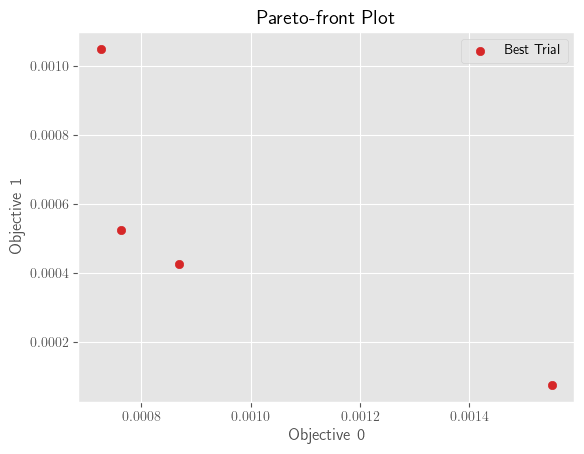

In [190]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [191]:
joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_one_step/trials.joblib']

Trial number 58
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.0015517820880929744, 7.720404443770567e-05]
Absolute motor values
{'hb_trans': [1.3783265676331258], 'vb_trans': [-0.22881862160108038], 'hb_pitch': [3.0072023011862297], 'vb_pitch': [3.001966313430247], 'hb_1': [236.8766000000014], 'hb_2': [111.63179999999997], 'vb_1': [133.62870000000012], 'vb_2': [226.01250000000033]}


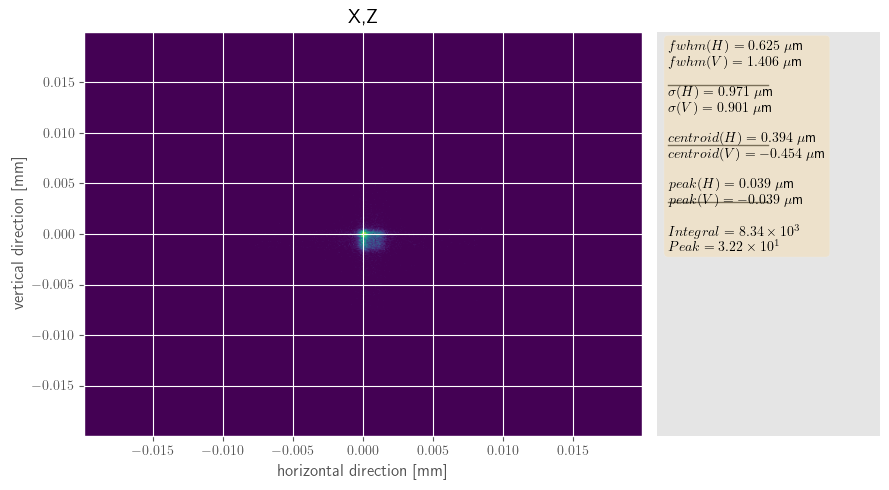

Trial number 66
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.0007627196949128243, 0.0005270271763897197]
Absolute motor values
{'hb_trans': [-1.2248212702530452], 'vb_trans': [0.07118137839891954], 'hb_pitch': [2.9949849964222692], 'vb_pitch': [3.001966313430247], 'hb_1': [213.1087000000014], 'hb_2': [119.53959999999998], 'vb_1': [130.4948000000001], 'vb_2': [242.25950000000034]}


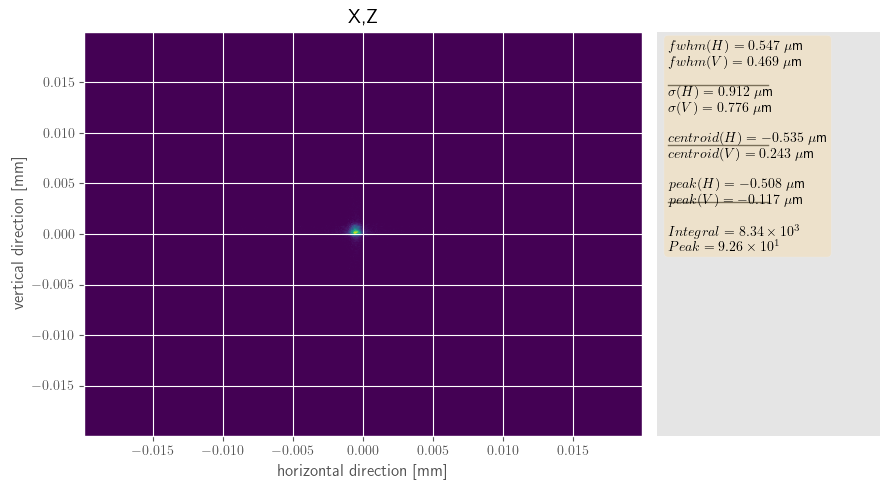

Trial number 71
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.0008693600495491393, 0.00042707167198573957]
Absolute motor values
{'hb_trans': [-1.6248212702530453], 'vb_trans': [-1.2286109552281133], 'hb_pitch': [2.9949849964222692], 'vb_pitch': [3.0054569719342354], 'hb_1': [203.67090000000138], 'hb_2': [121.60209999999998], 'vb_1': [142.5330000000001], 'vb_2': [199.96890000000036]}


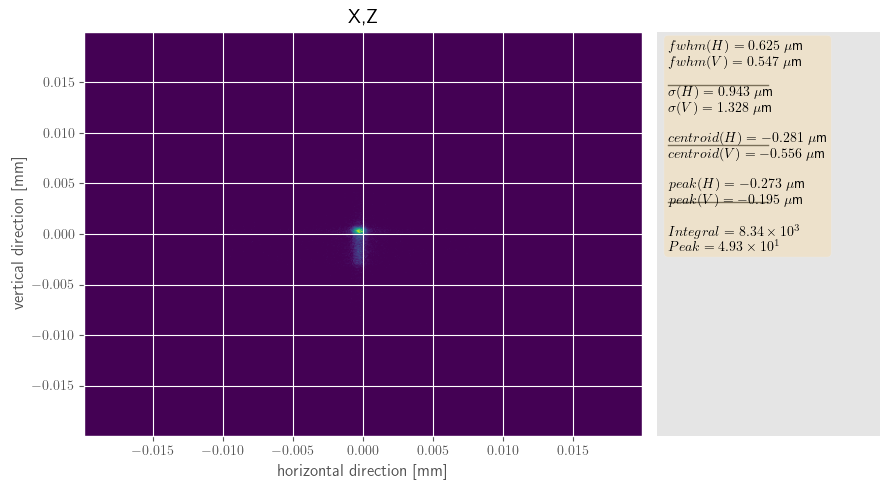

Trial number 112
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
[0.0007258822630527232, 0.00105008853357454]
Absolute motor values
{'hb_trans': [5.4499176747268505], 'vb_trans': [1.072518571619638], 'hb_pitch': [3.024655593706173], 'vb_pitch': [3.001966313430247], 'hb_1': [215.6147000000014], 'hb_2': [115.1614], 'vb_1': [158.66360000000006], 'vb_2': [238.28340000000037]}


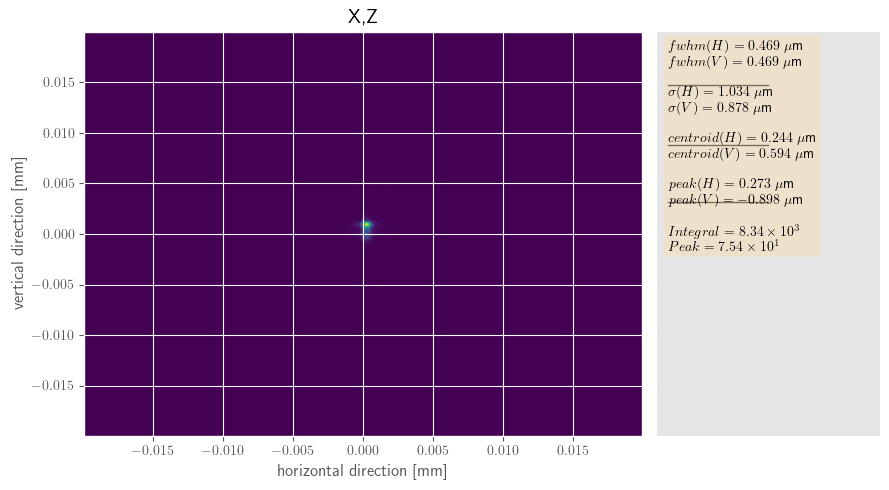

[0.00072588 0.00105009] None


In [192]:
for t in opt_trial.study.best_trials:
    print("Trial number", t.number)
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    
    
    
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    print("Absolute motor values")
    abs_motor_values = {mt: movers.get_absolute_positions(opt_trial.focusing_system, mt) for mt in opt_trial.motor_types}
    print(abs_motor_values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()

t = opt_trial.study.trials[-1]
current_params = []
for mot in opt_trial.motor_types:
    current_params.append(params[mot])
print(opt_trial._loss_fn_this(current_params), opt_trial.study.trials[-1].values)